# Long Text Classification ----  Clinical-Bert 

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
import os

os.chdir("/content/drive/My Drive/MIMIC/BERT_FineTune/bert_base")
os.listdir("/content/drive/My Drive/MIMIC/BERT_FineTune/bert_base")

Mounted at /content/drive/


['set_1',
 'checkpoint_epoch_10.pt',
 'loss_epoch_10.png',
 'epoch_10_test.png',
 'checkpoint_epoch_20.pt',
 'loss_epoch_20.png',
 'epoch_20_test.png',
 'checkpoint_epoch_30.pt',
 'loss_epoch_30.png',
 'epoch_30_test.png',
 'checkpoint_epoch_40.pt',
 'loss_epoch_40.png',
 'epoch_40_test.png',
 'checkpoint_epoch_50.pt',
 'loss_epoch_50.png',
 'epoch_50_test.png',
 'checkpoint_epoch_60.pt',
 'loss_epoch_60.png',
 'epoch_60_test.png',
 'checkpoint_epoch_70.pt',
 'loss_epoch_70.png',
 'epoch_70_test.png',
 'checkpoint_epoch_80.pt',
 'loss_epoch_80.png',
 'epoch_80_test.png',
 'checkpoint_epoch_90.pt',
 'loss_epoch_90.png',
 'epoch_90_test.png']

In [2]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.1 MB/s 
     |████████████████████████████████| 6.6 MB 52.0 MB/s 
     |████████████████████████████████| 120 kB 78.5 MB/s 


In [3]:
import pandas as pd
import numpy as np
import torch
import transformers
from transformers import BertTokenizer
from torch.utils.data import Dataset
import json

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc,roc_auc_score,f1_score,precision_score,recall_score
from sklearn.metrics import precision_recall_curve,average_precision_score,PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

In [4]:
# 产看配置
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Aug 23 15:38:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    48W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# utils

In [5]:
# 自制数据集
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.title = dataframe['text']
        self.targets = dataframe['labels']
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )

        ids = inputs['input_ids']  # 将 input 中的词 encode,把一句话变为一个一维的tensor, 向量长度为max-length, 如果文本过段，用0填充。
        mask = inputs['attention_mask']  # 用于 truncation
        token_type_ids = inputs["token_type_ids"]  # 第几句话
        return {
            'ids': torch.tensor(ids, dtype=torch.long),  # 数据 text ，经过encoder后的结果
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [6]:
# 加载模型
def load_ckp(checkpoint_fpath, model, optimizer):

    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training

    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min
# 保存模型
def save_ckp(state, checkpoint_path):
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)


# Dataset

In [7]:
#################################### prepare data ###############################
# load raw data
train_data = pd.read_csv('/content/drive/My Drive/MIMIC/caml-mimic/mimicdata/mimic3/train_50.csv')
test_data = pd.read_csv('/content/drive/My Drive/MIMIC/caml-mimic/mimicdata/mimic3/test_50.csv')
val_data = pd.read_csv('/content/drive/My Drive/MIMIC/caml-mimic/mimicdata/mimic3/dev_50.csv')

# 首先收集所有的 top 50 的标签，做成列表
top_50_list = []
top_50_code = pd.read_csv('/content/drive/My Drive/MIMIC/caml-mimic/mimicdata/mimic3/TOP_50_CODES.csv',header=None)
idx2code = {0: '038.9', 1: '244.9', 2: '250.00', 3: '272.0', 4: '272.4', 5: '276.1', 6: '276.2', 7: '285.1', 8: '285.9', 9: '287.5', 10: '305.1', 11: '311', 12: '33.24', 13: '36.15', 14: '37.22', 15: '37.23', 16: '38.91', 17: '38.93', 18: '39.61', 19: '39.95', 20: '401.9', 
            21: '403.90', 22: '410.71', 23: '412', 24: '414.01', 25: '424.0', 26: '427.31', 27: '428.0', 28: '45.13', 29: '486', 30: '496', 31: '507.0', 32: '511.9', 33: '518.81', 34: '530.81', 35: '584.9', 36: '585.9', 37: '599.0', 38: '88.56', 39: '88.72', 40: '96.04', 
            41: '96.6', 42: '96.71', 43: '96.72', 44: '99.04', 45: '99.15', 46: '995.92', 47: 'V15.82', 48: 'V45.81', 49: 'V58.61'}
for index in range(len(top_50_code[0])):
  #raw_info = top_50_code.iloc[index]
  #top_50_list.append(raw_info[0])
  top_50_list.append(idx2code[index])

# 讲一条病人的数据，转化为向量
def data_2_label(data_text,top_50_list):
  label = []
  labels = data_text.split(';')
  for element in top_50_list:
    if element in labels:
      label.append(1)
    else:
      label.append(0)
  return label

# 制作训练集
train_data_list = []
for index in range(len(train_data['LABELS'])):
  row_info = train_data.iloc[index]
  text = row_info[2]
  labels = data_2_label(row_info[3],top_50_list)
  train_data_list.append([text,labels])
  
train_data_df = pd.DataFrame(train_data_list)
train_data_df.columns = ["text", "labels"]

# 制作验证集
val_data_list = []
for index in range(len(val_data['LABELS'])):
  row_info = val_data.iloc[index]
  text = row_info[2]
  labels = data_2_label(row_info[3],top_50_list)
  val_data_list.append([text,labels])
  
val_data_df = pd.DataFrame(val_data_list)
val_data_df.columns = ["text", "labels"]

# 制作测试集
test_data_list = []
for index in range(len(test_data['LABELS'])):
  row_info = test_data.iloc[index]
  text = row_info[2]
  labels = data_2_label(row_info[3],top_50_list)
  test_data_list.append([text,labels])
  
test_data_df = pd.DataFrame(test_data_list)
test_data_df.columns = ["text", "labels"]



In [8]:
print(len(train_data_df),len(val_data_df),len(test_data_df))

8066 1573 1729


In [9]:
#数据集的参数
tokenizer = BertTokenizer.from_pretrained("emilyalsentzer/Bio_Discharge_Summary_BERT")
MAX_LEN = 128
batch_size = 32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
# 准备数据集 
training_set = CustomDataset(train_data_df, tokenizer, MAX_LEN)
val_set = CustomDataset(val_data_df, tokenizer, MAX_LEN)
test_set = CustomDataset(test_data_df, tokenizer, MAX_LEN)

# 把数据集做成 batch_size 的形式
train_iter = torch.utils.data.DataLoader(training_set, batch_size, shuffle=True)
val_iter = torch.utils.data.DataLoader(val_set, batch_size)
test_iter = torch.utils.data.DataLoader(test_set, batch_size)

# Model

In [10]:
# 微调 BERT
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained("emilyalsentzer/Bio_Discharge_Summary_BERT")
        self.l2 = torch.nn.Dropout(0.15)
        self.l3 = torch.nn.Linear(768, 50)
        self.l4 = torch.nn.Sigmoid()

    def forward(self, ids, mask, token_type_ids):
        output_all = self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2( output_all[1] )
        output_3 = self.l3(output_2)
        output_4 = self.l4(output_3)
        return output_4
        

In [11]:
model = BERTClass()
model.to(device)

Some weights of the model checkpoint at emilyalsentzer/Bio_Discharge_Summary_BERT were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

# 优化器

In [12]:
import math
import torch
from torch.optim import Optimizer
from torch.optim.optimizer import required
from torch.nn.utils import clip_grad_norm_
import logging
import abc
import sys

logger = logging.getLogger(__name__)


if sys.version_info >= (3, 4):
    ABC = abc.ABC
else:
    ABC = abc.ABCMeta('ABC', (), {})


class _LRSchedule(ABC):
    """ Parent of all LRSchedules here. """
    warn_t_total = False        # is set to True for schedules where progressing beyond t_total steps doesn't make sense
    def __init__(self, warmup=0.002, t_total=-1, **kw):
        """
        :param warmup:  what fraction of t_total steps will be used for linear warmup
        :param t_total: how many training steps (updates) are planned
        :param kw:
        """
        super(_LRSchedule, self).__init__(**kw)
        if t_total < 0:
            logger.warning("t_total value of {} results in schedule not being applied".format(t_total))
        if not 0.0 <= warmup < 1.0 and not warmup == -1:
            raise ValueError("Invalid warmup: {} - should be in [0.0, 1.0[ or -1".format(warmup))
        warmup = max(warmup, 0.)
        self.warmup, self.t_total = float(warmup), float(t_total)
        self.warned_for_t_total_at_progress = -1

    def get_lr(self, step, nowarn=False):
        """
        :param step:    which of t_total steps we're on
        :param nowarn:  set to True to suppress warning regarding training beyond specified 't_total' steps
        :return:        learning rate multiplier for current update
        """
        if self.t_total < 0:
            return 1.
        progress = float(step) / self.t_total
        ret = self.get_lr_(progress)
        # warning for exceeding t_total (only active with warmup_linear
        if not nowarn and self.warn_t_total and progress > 1. and progress > self.warned_for_t_total_at_progress:
            logger.warning(
                "Training beyond specified 't_total'. Learning rate multiplier set to {}. Please set 't_total' of {} correctly."
                    .format(ret, self.__class__.__name__))
            self.warned_for_t_total_at_progress = progress
        # end warning
        return ret

    def get_lr_(self, progress):
        """
        :param progress:    value between 0 and 1 (unless going beyond t_total steps) specifying training progress
        :return:            learning rate multiplier for current update
        """
        return 1.


class ConstantLR(_LRSchedule):
    def get_lr_(self, progress):
        return 1.


class WarmupCosineSchedule(_LRSchedule):
    """
    Linearly increases learning rate from 0 to 1 over `warmup` fraction of training steps.
    Decreases learning rate from 1. to 0. over remaining `1 - warmup` steps following a cosine curve.
    If `cycles` (default=0.5) is different from default, learning rate follows cosine function after warmup.
    """
    warn_t_total = True
    def __init__(self, warmup=0.002, t_total=-1, cycles=.5, **kw):
        """
        :param warmup:      see LRSchedule
        :param t_total:     see LRSchedule
        :param cycles:      number of cycles. Default: 0.5, corresponding to cosine decay from 1. at progress==warmup and 0 at progress==1.
        :param kw:
        """
        super(WarmupCosineSchedule, self).__init__(warmup=warmup, t_total=t_total, **kw)
        self.cycles = cycles

    def get_lr_(self, progress):
        if progress < self.warmup:
            return progress / self.warmup
        else:
            progress = (progress - self.warmup) / (1 - self.warmup)   # progress after warmup
            return 0.5 * (1. + math.cos(math.pi * self.cycles * 2 * progress))


class WarmupCosineWithHardRestartsSchedule(WarmupCosineSchedule):
    """
    Linearly increases learning rate from 0 to 1 over `warmup` fraction of training steps.
    If `cycles` (default=1.) is different from default, learning rate follows `cycles` times a cosine decaying
    learning rate (with hard restarts).
    """
    def __init__(self, warmup=0.002, t_total=-1, cycles=1., **kw):
        super(WarmupCosineWithHardRestartsSchedule, self).__init__(warmup=warmup, t_total=t_total, cycles=cycles, **kw)
        assert(cycles >= 1.)

    def get_lr_(self, progress):
        if progress < self.warmup:
            return progress / self.warmup
        else:
            progress = (progress - self.warmup) / (1 - self.warmup)     # progress after warmup
            ret = 0.5 * (1. + math.cos(math.pi * ((self.cycles * progress) % 1)))
            return ret


class WarmupCosineWithWarmupRestartsSchedule(WarmupCosineWithHardRestartsSchedule):
    """
    All training progress is divided in `cycles` (default=1.) parts of equal length.
    Every part follows a schedule with the first `warmup` fraction of the training steps linearly increasing from 0. to 1.,
    followed by a learning rate decreasing from 1. to 0. following a cosine curve.
    """
    def __init__(self, warmup=0.002, t_total=-1, cycles=1., **kw):
        assert(warmup * cycles < 1.)
        warmup = warmup * cycles if warmup >= 0 else warmup
        super(WarmupCosineWithWarmupRestartsSchedule, self).__init__(warmup=warmup, t_total=t_total, cycles=cycles, **kw)

    def get_lr_(self, progress):
        progress = progress * self.cycles % 1.
        if progress < self.warmup:
            return progress / self.warmup
        else:
            progress = (progress - self.warmup) / (1 - self.warmup)     # progress after warmup
            ret = 0.5 * (1. + math.cos(math.pi * progress))
            return ret


class WarmupConstantSchedule(_LRSchedule):
    """
    Linearly increases learning rate from 0 to 1 over `warmup` fraction of training steps.
    Keeps learning rate equal to 1. after warmup.
    """
    def get_lr_(self, progress):
        if progress < self.warmup:
            return progress / self.warmup
        return 1.


class WarmupLinearSchedule(_LRSchedule):
    """
    Linearly increases learning rate from 0 to 1 over `warmup` fraction of training steps.
    Linearly decreases learning rate from 1. to 0. over remaining `1 - warmup` steps.
    """
    warn_t_total = True
    def get_lr_(self, progress):
        if progress < self.warmup:
            return progress / self.warmup
        return max((progress - 1.) / (self.warmup - 1.), 0.)


SCHEDULES = {
    None:       ConstantLR,
    "none":     ConstantLR,
    "warmup_cosine": WarmupCosineSchedule,
    "warmup_constant": WarmupConstantSchedule,
    "warmup_linear": WarmupLinearSchedule
}


class BertAdam(Optimizer):
    """Implements BERT version of Adam algorithm with weight decay fix.
    Params:
        lr: learning rate
        warmup: portion of t_total for the warmup, -1  means no warmup. Default: -1
        t_total: total number of training steps for the learning
            rate schedule, -1  means constant learning rate of 1. (no warmup regardless of warmup setting). Default: -1
        schedule: schedule to use for the warmup (see above).
            Can be `'warmup_linear'`, `'warmup_constant'`, `'warmup_cosine'`, `'none'`, `None` or a `_LRSchedule` object (see below).
            If `None` or `'none'`, learning rate is always kept constant.
            Default : `'warmup_linear'`
        b1: Adams b1. Default: 0.9
        b2: Adams b2. Default: 0.999
        e: Adams epsilon. Default: 1e-6
        weight_decay: Weight decay. Default: 0.01
        max_grad_norm: Maximum norm for the gradients (-1 means no clipping). Default: 1.0
    """
    def __init__(self, params, lr=required, warmup=-1, t_total=-1, schedule='warmup_linear',
                 b1=0.9, b2=0.999, e=1e-6, weight_decay=0.01, max_grad_norm=1.0, **kwargs):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {} - should be >= 0.0".format(lr))
        if not isinstance(schedule, _LRSchedule) and schedule not in SCHEDULES:
            raise ValueError("Invalid schedule parameter: {}".format(schedule))
        if not 0.0 <= b1 < 1.0:
            raise ValueError("Invalid b1 parameter: {} - should be in [0.0, 1.0[".format(b1))
        if not 0.0 <= b2 < 1.0:
            raise ValueError("Invalid b2 parameter: {} - should be in [0.0, 1.0[".format(b2))
        if not e >= 0.0:
            raise ValueError("Invalid epsilon value: {} - should be >= 0.0".format(e))
        # initialize schedule object
        if not isinstance(schedule, _LRSchedule):
            schedule_type = SCHEDULES[schedule]
            schedule = schedule_type(warmup=warmup, t_total=t_total)
        else:
            if warmup != -1 or t_total != -1:
                logger.warning("warmup and t_total on the optimizer are ineffective when _LRSchedule object is provided as schedule. "
                               "Please specify custom warmup and t_total in _LRSchedule object.")
        defaults = dict(lr=lr, schedule=schedule,
                        b1=b1, b2=b2, e=e, weight_decay=weight_decay,
                        max_grad_norm=max_grad_norm)
        super(BertAdam, self).__init__(params, defaults)

    def get_lr(self):
        lr = []
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                if len(state) == 0:
                    return [0]
                lr_scheduled = group['lr']
                lr_scheduled *= group['schedule'].get_lr(state['step'])
                lr.append(lr_scheduled)
        return lr

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['next_m'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['next_v'] = torch.zeros_like(p.data)

                next_m, next_v = state['next_m'], state['next_v']
                beta1, beta2 = group['b1'], group['b2']

                # Add grad clipping
                if group['max_grad_norm'] > 0:
                    clip_grad_norm_(p, group['max_grad_norm'])

                # Decay the first and second moment running average coefficient
                # In-place operations to update the averages at the same time
                next_m.mul_(beta1).add_(1 - beta1, grad)
                next_v.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                update = next_m / (next_v.sqrt() + group['e'])

                # Just adding the square of the weights to the loss function is *not*
                # the correct way of using L2 regularization/weight decay with Adam,
                # since that will interact with the m and v parameters in strange ways.
                #
                # Instead we want to decay the weights in a manner that doesn't interact
                # with the m/v parameters. This is equivalent to adding the square
                # of the weights to the loss with plain (non-momentum) SGD.
                if group['weight_decay'] > 0.0:
                    update += group['weight_decay'] * p.data

                lr_scheduled = group['lr']
                lr_scheduled *= group['schedule'].get_lr(state['step'])

                update_with_lr = lr_scheduled * update
                p.data.add_(-update_with_lr)

                state['step'] += 1

                # step_size = lr_scheduled * math.sqrt(bias_correction2) / bias_correction1
                # No bias correction
                # bias_correction1 = 1 - beta1 ** state['step']
                # bias_correction2 = 1 - beta2 ** state['step']

        return loss

# Train

In [13]:
import sys
import numpy as np
sys.path.append("/content/drive/My Drive/MIMIC/caml-mimic")  # 注意，这里改变了地址了
import evaluation

In [14]:
def get_roc_auc(val_targets,val_outputs):
  # input : val_targets 标签 ； val_outputs 模型的输出 (需要np.array类型)
  # output: return_fpr (micro,macro) , return_tpr (micro,macro) (list)
  # output: return_roc_auc (micro,macro)  (float)
  # Compute ROC curve and ROC area for each class
  n_classes = len(val_targets[0]) # [num_example,num_class] 
  fpr = {}
  tpr = {}
  roc_auc = {}
  for i in range(n_classes):
    fpr_, tpr_, _ = roc_curve(val_targets[:, i], val_outputs[:, i])
    fpr[i] = fpr_.tolist()
    tpr[i] = tpr_.tolist()
    roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr_, tpr_, _ = roc_curve(val_targets.ravel(), val_outputs.ravel())
  fpr['micro'] = fpr_.tolist()
  tpr['micro'] = tpr_.tolist()
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # Compute macro-average ROC curve and ROC area
  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
  # Finally average it and compute AUC
  mean_tpr /= n_classes
  fpr["macro"] = all_fpr.tolist()
  tpr["macro"] = mean_tpr.tolist()
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # 返回时，我们只需要micro,macro的信息即可
  return_fpr = {'macro':fpr['macro'],'micro':fpr['micro']}
  return_tpr = {'macro':tpr['macro'],'micro':tpr['micro']}
  return_roc_auc = {'macro':roc_auc['macro'],'micro':roc_auc['micro']}
  return return_fpr,return_tpr,return_roc_auc

def epoch_perform(y_target,y_output):
  # 计算 prediction , 以 0.5 作为阈值
  # 输出 mretics
  '''
  'acc_macro','prec_macro','rec_macro','f1_macro'
  'acc_micro','prec_micro','rec_micro','f1_micro',
  'rec_at_5','prec_at_5', 'f1_at_5' , 
  'auc_macro','auc_micro','auc',
  'tpr','fpr',
  'prec_micro_curve','rec_micro,curve','ave_prec_micro'
  '''
  y_output = torch.tensor(y_output)
  ones = torch.ones_like(y_output)
  zeros = torch.zeros_like(y_output)
  y_prediction = torch.where(y_output > 0.5 , ones , zeros)
  y_output = y_output.cpu().detach().numpy()
  print()
  print('The evluation from other code:')
  metrics = evaluation.all_metrics(y_prediction.numpy(), y_target, k=5, yhat_raw= y_output)
  print(evaluation.print_metrics(metrics))
  # 计算 tpr ,fpr, 用于画出 ROC_AUCROC_AUC
  fpr,tpr,roc_auc = get_roc_auc(y_target,y_output)
  metrics['auc'] = roc_auc
  metrics['fpr'] = fpr
  metrics['tpr'] = tpr
  print(metrics['auc'])
  print()
  # 计算 precision,recall ,用于画出 precision-recall curve
  precision ={}
  recall = {}
  average_precision = {}
  metrics['prec_micro_curve'], metrics['rec_micro,curve'], _ = precision_recall_curve(y_target.ravel(), y_output.ravel())
  metrics['ave_prec_micro'] = average_precision_score(y_target, y_output, average="micro")
  return metrics

'''
def get_f1_pre_re(y_target,y_output):
  # 计算 F1 ， precision , recall
  y_output = torch.tensor(y_output)
  ones = torch.ones_like(y_output)
  zeros = torch.zeros_like(y_output)
  y_prediction = torch.where(y_output > 0.5 , ones , zeros)
  # 为了与其他的模型比较效果，我们放弃直接使用skearn的函数，转而使用其他的函数
  result['f1 micro'] = f1_score(y_target, y_prediction, average='micro')
  result['f1 macro'] = f1_score(y_target, y_prediction, average='macro')
  result['precision micro'] = precision_score(y_target, y_prediction, average='micro')
  result['precision macro'] = precision_score(y_target, y_prediction, average='macro')
  result['recall micro'] = recall_score(y_target, y_prediction, average='micro')
  result['recall macro'] = recall_score(y_target, y_prediction, average='macro')
  print()
  print('The evluation from other code:')
  metrics = evaluation.all_metrics(y_prediction, y_target, k=5, yhat_raw= y_output)
  print(evaluation.print_metrics(metrics))
  
  'acc_macro','prec_macro','rec_macro','f1_macro'
  'acc_micro','prec_micro','rec_micro','f1_micro',
  'rec_at_5','prec_at_5', 'f1_at_5' , 
  'auc_macro','auc_micro'
  
  return metrics


def epoch_perform(targets,outputs,name):
  performence = get_f1_pre_re(targets,outputs)
  fpr,tpr,roc_auc = get_roc_auc(targets,outputs)
  performence['auc'] = roc_auc
  performence['fpr'] = fpr
  performence['tpr'] = tpr
  print()
  print(name+' performence:')
  print('auc(micro): ',roc_auc['micro'],'\tauc(macro):',roc_auc['macro'])
  print('precision(micro):',performence['precision micro'],
        '\tprecison(macro):',performence['precision macro'],
        '\trecall(micro):',performence['recall micro'],
        '\trecall(macro):',performence['recall macro'],
        '\tf_1 (micro):',performence['f1 micro'],
        '\tf_1 (macro):',performence['f1 macro'])
  return performence
'''

"\ndef get_f1_pre_re(y_target,y_output):\n  # 计算 F1 ， precision , recall\n  y_output = torch.tensor(y_output)\n  ones = torch.ones_like(y_output)\n  zeros = torch.zeros_like(y_output)\n  y_prediction = torch.where(y_output > 0.5 , ones , zeros)\n  # 为了与其他的模型比较效果，我们放弃直接使用skearn的函数，转而使用其他的函数\n  result['f1 micro'] = f1_score(y_target, y_prediction, average='micro')\n  result['f1 macro'] = f1_score(y_target, y_prediction, average='macro')\n  result['precision micro'] = precision_score(y_target, y_prediction, average='micro')\n  result['precision macro'] = precision_score(y_target, y_prediction, average='macro')\n  result['recall micro'] = recall_score(y_target, y_prediction, average='micro')\n  result['recall macro'] = recall_score(y_target, y_prediction, average='macro')\n  print()\n  print('The evluation from other code:')\n  metrics = evaluation.all_metrics(y_prediction, y_target, k=5, yhat_raw= y_output)\n  print(evaluation.print_metrics(metrics))\n  \n  'acc_macro','prec_macro','rec_m

In [15]:
def draw_pr_roc(test_performence,
                y_target,y_output,
                save_path,epoch,name,
                key):
  # fpr, tpr,roc_auc 三个字典，是 get_roc_auc的输出
  # y_target 标签 ； y_output 模型的输出
  # save_path 保存图片的地址 ； epoch,name 记录是哪一次的信息
  # 输出： 两张图表，roc曲线 和 precision_recall曲线
  # 画图，首先是左边，roc_auc 曲线
  fig, axs = plt.subplots(1, 2, figsize=(21, 10))
  axs[0].step(
      test_performence['fpr']["micro"],
      test_performence['tpr']["micro"],
      label="micro-average ROC curve (area = {0:0.2f})".format(test_performence['auc']["micro"]),
      color='#f97306', # "deeppink" 红，"#01ff07"绿,'#9a0eea'紫 ,'#f97306'橙
      #linestyle=":",
      linewidth=2,)
  axs[0].step(
      test_performence['fpr']["macro"],
      test_performence['tpr']["macro"],
      label="macro-average ROC curve (area = {0:0.2f})".format(test_performence['auc']["macro"]),
      color='#9a0eea', # "deeppink" 红，"#01ff07"绿,'#9a0eea'紫 ,'#f97306'橙
      #linestyle=":",
      linewidth=2,
    ) 
  axs[0].plot([0, 1], [0, 1], "k--", lw=2)
  axs[0].set_xlim([0.0, 1.0])
  axs[0].set_ylim([0.0, 1.05])
  axs[0].set_xlabel("False Positive Rate")
  axs[0].set_ylabel("True Positive Rate")
  axs[0].set_title("Receiver Operating Characteristic to multiclass")

  # 然后是右边，precision_recall curve
  f_scores = np.linspace(0.2, 0.8, num=4)
  lines, labels = [], []
  for f_score in f_scores:
      x = np.linspace(0.01, 1)
      y = f_score * x / (2 * x - f_score)
      (l,) = axs[1].plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
      axs[1].annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

  display = PrecisionRecallDisplay(
      recall=test_performence['rec_micro,curve'],
      precision=test_performence['prec_micro_curve'],
      average_precision = test_performence['prec_micro'],
  )
  display.plot(ax=axs[1], name="Micro-average precision-recall", 
               color="#f97306",linewidth=2) 

  # add the legend for the iso-f1 curves
  handles, labels = display.ax_.get_legend_handles_labels()
  handles.extend([l])
  labels.extend(["iso-f1 curves"])
  # set the legend and the axes
  axs[1].set_xlim([0.0, 1.0])
  axs[1].set_ylim([0.0, 1.05])
  axs[1].legend(handles=handles, labels=labels, loc="best")
  axs[1].set_title("Micro-averaged Prcision-Recall Line")

  for ax in axs:
    ax.legend(loc="lower right")
  plt.show()
  if key == 1:
    fig.savefig(fname =save_path+'/epoch_'+str(epoch)+'_'+name+'.png')

#draw_pr_roc(return_fpr,return_tpr,return_roc_auc,Y,y_score,
#            save_path='/content/drive/My Drive/MIMIC',epoch=1,name='val')

In [16]:
def draw_loss(result_loss,save_path,key):
  fig, axs = plt.subplots(2, 3, figsize=(24, 16))
  # 可视化 train_loss_batch
  x = np.arange(0,len(result_loss['train_loss_batch']),1)
  y = np.array(result_loss['train_loss_batch'])
  axs[0][0].plot( x, y,
      #label="micro-average ROC curve (area = {0:0.2f})".format(return_roc_auc["micro"]),
      color='#f97306', # "deeppink" 红，"#01ff07"绿,'#9a0eea'紫 ,'#f97306'橙
      #linestyle=":",
      linewidth=2,)
  #axs[0][0].set_xlim([0.0, 1.0])
  #axs[0][0].set_ylim([0.0, 1.05])
  axs[0][0].set_xlabel("epoch")
  axs[0][0].set_ylabel("Loss")
  axs[0][0].set_title("Train Loss per Batchs")
  
  # 可视化 train_loss_epoch
  x = np.arange(0,len(result_loss['train_loss_epoch']),1)
  y = np.array(result_loss['train_loss_epoch'])
  print(x)
  print(y)
  axs[0][1].plot( x, y,
      #label="micro-average ROC curve (area = {0:0.2f})".format(return_roc_auc["micro"]),
      color='#f97306', # "deeppink" 红，"#01ff07"绿,'#9a0eea'紫 ,'#f97306'橙
      #linestyle=":",
      linewidth=2,)
  #axs[0][1].set_xlim([0.0, 1.0])
  #axs[0][1].set_ylim([0.0, 1.05])
  axs[0][1].set_xlabel("epoch")
  axs[0][1].set_ylabel("Loss")
  axs[0][1].set_title("Train Loss per Epoch")
  
  # 可视化 test_loss_epoch
  x = np.arange(0,len(result_loss['test_loss_epoch']),1)
  y = np.array(result_loss['test_loss_epoch'])
  axs[0][2].plot( x, y,
      #label="micro-average ROC curve (area = {0:0.2f})".format(return_roc_auc["micro"]),
      color='#f97306', # "deeppink" 红，"#01ff07"绿,'#9a0eea'紫 ,'#f97306'橙
      #linestyle=":",
      linewidth=2,)
  #axs[1][0].set_xlim([0.0, 1.0])
  #axs[1][0].set_ylim([0.0, 1.05])
  axs[0][2].set_xlabel("epoch")
  axs[0][2].set_ylabel("Loss")
  axs[0][2].set_title("Test Loss per Epoch")
  
  # 可视化 F 1
  x = np.arange(0,len(result_loss['test_macro_f1']),1)
  y = np.array(result_loss['test_macro_f1'])
  axs[1][0].plot( x, y,
      #label="micro-average ROC curve (area = {0:0.2f})".format(return_roc_auc["micro"]),
      color='#f97306', # "deeppink" 红，"#01ff07"绿,'#9a0eea'紫 ,'#f97306'橙
      #linestyle=":",
      label = "F1(macro)",
      linewidth=2,)
  x = np.arange(0,len(result_loss['test_micro_f1']),1)
  y = np.array(result_loss['test_micro_f1'])
  axs[1][0].plot( x, y,
      #label="micro-average ROC curve (area = {0:0.2f})".format(return_roc_auc["micro"]),
      color='#9a0eea', # "deeppink" 红，"#01ff07"绿,'#9a0eea'紫 ,'#f97306'橙
      #linestyle=":",
      label = "F1(micro)",
      linewidth=2,)
  #axs[1][1].set_xlim([0.0, 1.0])
  #axs[1][1].set_ylim([0.0, 1.05])
  axs[1][0].set_xlabel("epoch")
  axs[1][0].set_ylabel("F 1 score")
  axs[1][0].set_title("F 1 score per Epoch")
  axs[1][0].legend()

  # 可视化 Recall
  x = np.arange(0,len(result_loss['test_macro_recall']),1)
  y = np.array(result_loss['test_macro_recall'])
  axs[1][1].plot( x, y,
      #label="micro-average ROC curve (area = {0:0.2f})".format(return_roc_auc["micro"]),
      color='#f97306', # "deeppink" 红，"#01ff07"绿,'#9a0eea'紫 ,'#f97306'橙
      #linestyle=":",
      label = "Recall (macro)",
      linewidth=2,)
  x = np.arange(0,len(result_loss['test_micro_recall']),1)
  y = np.array(result_loss['test_micro_recall'])
  axs[1][1].plot( x, y,
      #label="micro-average ROC curve (area = {0:0.2f})".format(return_roc_auc["micro"]),
      color='#9a0eea', # "deeppink" 红，"#01ff07"绿,'#9a0eea'紫 ,'#f97306'橙
      label = "Recall (micro)",
      #linestyle=":",
      linewidth=2,)
  #axs[1][1].set_xlim([0.0, 1.0])
  #axs[1][1].set_ylim([0.0, 1.05])
  axs[1][1].set_xlabel("epoch")
  axs[1][1].set_ylabel("Recall score")
  axs[1][1].set_title("Recall score per Epoch")
  axs[1][1].legend()
  # 可视化 Precision
  x = np.arange(0,len(result_loss['test_macro_precision']),1)
  y = np.array(result_loss['test_macro_precision'])
  axs[1][2].plot( x, y,
      #label="micro-average ROC curve (area = {0:0.2f})".format(return_roc_auc["micro"]),
      color='#f97306', # "deeppink" 红，"#01ff07"绿,'#9a0eea'紫 ,'#f97306'橙
      #linestyle=":",
      label = "Precision (macro)",
      linewidth=2,)
  x = np.arange(0,len(result_loss['test_micro_precision']),1)
  y = np.array(result_loss['test_micro_precision'])
  axs[1][2].plot( x, y,
      #label="micro-average ROC curve (area = {0:0.2f})".format(return_roc_auc["micro"]),
      color='#9a0eea', # "deeppink" 红，"#01ff07"绿,'#9a0eea'紫 ,'#f97306'橙
      #linestyle=":",
      label = "Precision (micro)",
      linewidth=2,)
  #axs[1][1].set_xlim([0.0, 1.0])
  #axs[1][1].set_ylim([0.0, 1.05])
  axs[1][2].set_xlabel("epoch")
  axs[1][2].set_ylabel("Precision score")
  axs[1][2].set_title("Precision score per Epoch")
  axs[1][2].legend()
  plt.show()
  if key == 1:
    fig.savefig(fname =save_path+'/loss_epoch_'+str(epoch)+'.png')


In [17]:
# 设置参数
checkpoint_path = '/content/drive/My Drive/MIMIC/BERT_FineTune/clinical-bert'
model_name = 'clinical-bert'

LEARNING_RATE = 2e-05

start_epochs = 1
n_epochs = 100

# 损失函数
def loss_fn(outputs, targets):
    #return torch.nn.functional.cross_entropy(outputs, targets)
    return torch.nn.functional.binary_cross_entropy(outputs,targets)

# 优化器，使用 warm up ,  AdmaW
# optimizer = torch.optim.Adam(params = model.parameters(), lr=LEARNING_RATE)
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]
# optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE)

#optimizer = BertAdam(optimizer_grouped_parameters,
#                      lr=LEARNING_RATE,
#                      warmup=0.05,
#                      t_total=len(train_iter) * n_epochs)
#sigmoid = torch.nn.Sigmoid()

In [ ]:
# 正式开始训练
result_loss = {'train_loss_batch':[],'train_loss_epoch':[],'test_loss_epoch':[],
               'test_macro_f1':[],'test_macro_recall':[],'test_macro_precision':[],
               'test_micro_f1':[],'test_micro_recall':[],'test_micro_precision':[],
               'test_macro_auc':[],'test_micro_auc':[]}

test_loss_min  = np.Inf  # 初始化最小的验证损失函数
for epoch in range(start_epochs, n_epochs+1):
  key = 0  # 用于提示合适保存图片
  test_targets = []
  test_outputs = []
  train_loss = 0
  test_loss = 0

  ######################    
   # Train the model #
  ######################
  process_num = 0  
  model.train()
  print('###############   Epoch {}: Training Start   #############'.format(epoch))
  for batch_idx, data in enumerate(train_iter):
    ids = data['ids'].to(device, dtype = torch.long)
    mask = data['mask'].to(device, dtype = torch.long)
    token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
    targets = data['targets'].to(device, dtype = torch.float)

    outputs = model(ids, mask, token_type_ids)  

    optimizer.zero_grad()
    loss = loss_fn(outputs, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
    # 记录信息
    process_num += batch_size
    if process_num % (64*20) == 0:  ############## 这里可以调
      print('already deal with '+ str(process_num)+' data','\tloss:',loss.item())
      result_loss['train_loss_batch'].append(loss.item())
  train_loss = train_loss/len(train_iter)  # 计算平均训练损失
  result_loss['train_loss_epoch'].append(train_loss) # 放到记录字典里
  print('Epoch {}: Training End'.format(epoch))

  ######################    
  # validate the model #
  ######################
  model.eval()
  with torch.no_grad():
    # 在 测试集上跑一遍
    for batch_idx, data in enumerate(test_iter, 0):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.float)

      outputs = model(ids, mask, token_type_ids)

      loss = loss_fn(outputs, targets)
      test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.item() - test_loss))
      test_targets.extend(targets.cpu().detach().numpy())
      test_outputs.extend(outputs.cpu().detach().numpy())
    test_loss = test_loss / len(test_iter)
    result_loss['test_loss_epoch'].append(test_loss)
    print('Epoch {}: Validation End'.format(epoch))
    # 打印一下 三个损失函数 
    print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Test Loss: {:.6f}'.format(epoch, train_loss,test_loss))

  #####################################
  ######### 记录结果, 保存模型  #########
  #####################################
  test_performence = epoch_perform(np.array(test_targets),np.array(test_outputs)) # 得到模型在test集合上的表现
  result_loss['test_macro_f1'].append(test_performence['f1_macro'])
  result_loss['test_micro_f1'].append(test_performence['f1_micro'])
  result_loss['test_macro_recall'].append(test_performence['rec_macro'])
  result_loss['test_micro_recall'].append(test_performence['rec_micro'])
  result_loss['test_macro_precision'].append(test_performence['prec_macro'])
  result_loss['test_micro_precision'].append(test_performence['prec_micro'])
  result_loss['test_macro_auc'].append(test_performence['auc_macro'])
  result_loss['test_micro_auc'].append(test_performence['auc_micro'])

  # 下面要保存模型
  checkpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'test_outputs':np.array(test_outputs),
            'test_targets':np.array(test_targets),
            'loss':result_loss,
            'test_performence':test_performence}
  if epoch % 10 == 0 :  # 这里是真的要保存了  # 记着设置保存条件
    key = 1
    # 保存模型
    save_ckp(checkpoint, checkpoint_path+'/checkpoint_epoch_'+ str(epoch) + '.pt' )
    # 保存test , loss 字典
    #test_json = json.dumps(test_performence,sort_keys=False, indent=4, separators=(',', ': '))
    #loss_json = json.dumps(result_loss,sort_keys=False, indent=4, separators=(',', ': '))
    #f = open(checkpoint_path + '/test_performence_epoch_'+ str(epoch) +'.json', 'w')
    #f.write(test_json)
    #f = open(checkpoint_path + '/loss_epoch_'+ str(epoch) +'.json', 'w')
    #f.write(loss_json)

  #####################################
  ######### 可视化，打印  #########
  #####################################
  print('Visulization:')
  print("Loss :")
  print(result_loss)
  draw_loss(result_loss,checkpoint_path,key)
  print('test: ')
  draw_pr_roc(test_performence,
              np.array(test_targets),np.array(test_outputs),   # np 优化
              checkpoint_path,epoch,'test',
              key)

Output hidden; open in https://colab.research.google.com to view.

# Evaluation

In [ ]:
! pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 11.3 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [18]:
checkpoint_fpath = "/content/drive/My Drive/MIMIC/BERT_FineTune/clinical-bert/checkpoint_epoch_40.pt"


#load_ckp(checkpoint_fpath, model, optimizer)
# load check point
checkpoint = torch.load(checkpoint_fpath)
# initialize state_dict from checkpoint to model
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [19]:
valid_loss = 0
val_targets = []
val_outputs = []
with torch.no_grad():
  # 在 测试集上跑一遍
  for batch_idx, data in enumerate(val_iter, 0):
    ids = data['ids'].to(device, dtype = torch.long)
    mask = data['mask'].to(device, dtype = torch.long)
    token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
    targets = data['targets'].to(device, dtype = torch.float)

    outputs = model(ids, mask, token_type_ids)

    loss = loss_fn(outputs, targets)
    #loss_list.append(loss)
    valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
    val_targets.extend( targets.cpu().detach().numpy())
    val_outputs.extend( outputs.cpu().detach().numpy()) 
  valid_loss = valid_loss / len(val_iter)
  #result_loss['valid_loss_epoch'].append(valid_loss)
  print('valid loss:',valid_loss)

valid loss: 0.007980441915988921


In [20]:
val_targets = np.array(val_targets)
val_outputs = np.array(val_outputs)

In [21]:
# 利用 output 做出 prediction
ones = torch.ones_like(torch.tensor(val_outputs))
zeros = torch.zeros_like(torch.tensor(val_outputs))
val_prediction = torch.where(torch.tensor(val_outputs) > 0.5 , ones , zeros)
val_prediction = np.array(val_prediction)

In [22]:
from sklearn.metrics import roc_auc_score

print('AUC:')
print('macro:',roc_auc_score(val_targets, val_outputs, average='macro'))
print('micro:',roc_auc_score(val_targets, val_outputs, average='micro'))
print('F1:')
print('macro:',f1_score(val_targets, val_prediction, average='macro'))
print('micro:',f1_score(val_targets, val_prediction, average='micro'))

AUC:
macro: 0.7520302224456116
micro: 0.79088013667913
F1:
macro: 0.3490256329963718
micro: 0.42779098913811936


In [23]:
# 保存模型在 valid dataset 上得到的结果
path = "/content/drive/My Drive/MIMIC/BERT_FineTune/clinical-bert/"
with open(path + 'clinical_val_targets.npy', 'wb') as f:  
  np.save(f, val_targets)
with open(path + 'clinical_val_predictions.npy', 'wb') as f:  
  np.save(f, val_prediction)
with open(path + 'clinical_val_outputs.npy', 'wb') as f:  
  np.save(f, val_outputs)
print('Finish save rediction by checkpoint')


Finish save rediction by checkpoint


label  0


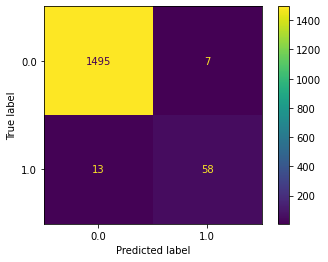

report:
              precision    recall  f1-score   support

     class 0       0.99      1.00      0.99      1502
     class 1       0.89      0.82      0.85        71

    accuracy                           0.99      1573
   macro avg       0.94      0.91      0.92      1573
weighted avg       0.99      0.99      0.99      1573



label  1


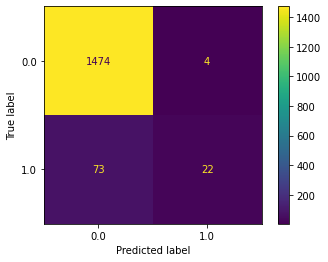

report:
              precision    recall  f1-score   support

     class 0       0.95      1.00      0.97      1478
     class 1       0.85      0.23      0.36        95

    accuracy                           0.95      1573
   macro avg       0.90      0.61      0.67      1573
weighted avg       0.95      0.95      0.94      1573



label  2


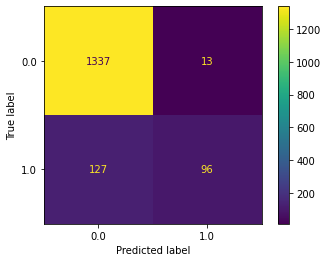

report:
              precision    recall  f1-score   support

     class 0       0.91      0.99      0.95      1350
     class 1       0.88      0.43      0.58       223

    accuracy                           0.91      1573
   macro avg       0.90      0.71      0.76      1573
weighted avg       0.91      0.91      0.90      1573



label  3


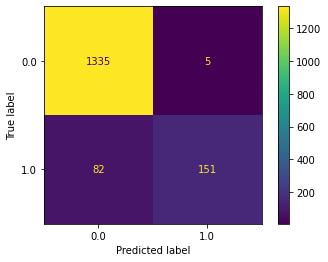

report:
              precision    recall  f1-score   support

     class 0       0.94      1.00      0.97      1340
     class 1       0.97      0.65      0.78       233

    accuracy                           0.94      1573
   macro avg       0.96      0.82      0.87      1573
weighted avg       0.95      0.94      0.94      1573



label  4


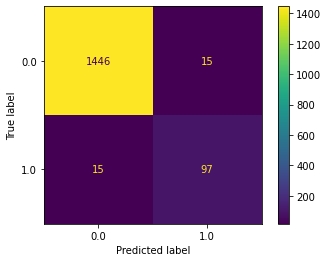

report:
              precision    recall  f1-score   support

     class 0       0.99      0.99      0.99      1461
     class 1       0.87      0.87      0.87       112

    accuracy                           0.98      1573
   macro avg       0.93      0.93      0.93      1573
weighted avg       0.98      0.98      0.98      1573



label  5


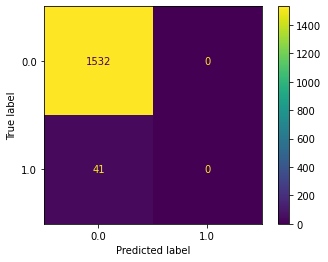

report:
              precision    recall  f1-score   support

     class 0       0.97      1.00      0.99      1532
     class 1       0.00      0.00      0.00        41

    accuracy                           0.97      1573
   macro avg       0.49      0.50      0.49      1573
weighted avg       0.95      0.97      0.96      1573



label  6


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


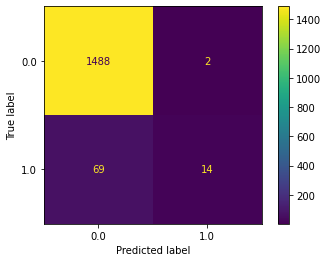

report:
              precision    recall  f1-score   support

     class 0       0.96      1.00      0.98      1490
     class 1       0.88      0.17      0.28        83

    accuracy                           0.95      1573
   macro avg       0.92      0.58      0.63      1573
weighted avg       0.95      0.95      0.94      1573



label  7


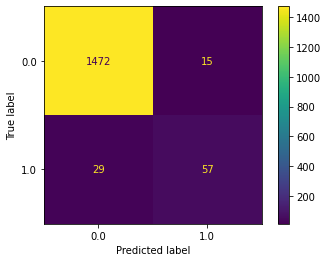

report:
              precision    recall  f1-score   support

     class 0       0.98      0.99      0.99      1487
     class 1       0.79      0.66      0.72        86

    accuracy                           0.97      1573
   macro avg       0.89      0.83      0.85      1573
weighted avg       0.97      0.97      0.97      1573



label  8


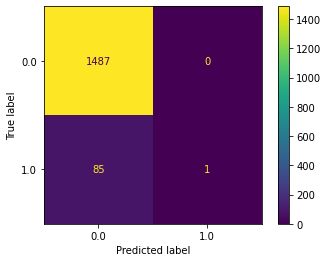

report:
              precision    recall  f1-score   support

     class 0       0.95      1.00      0.97      1487
     class 1       1.00      0.01      0.02        86

    accuracy                           0.95      1573
   macro avg       0.97      0.51      0.50      1573
weighted avg       0.95      0.95      0.92      1573



label  9


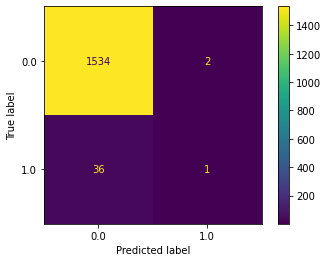

report:
              precision    recall  f1-score   support

     class 0       0.98      1.00      0.99      1536
     class 1       0.33      0.03      0.05        37

    accuracy                           0.98      1573
   macro avg       0.66      0.51      0.52      1573
weighted avg       0.96      0.98      0.97      1573



label  10


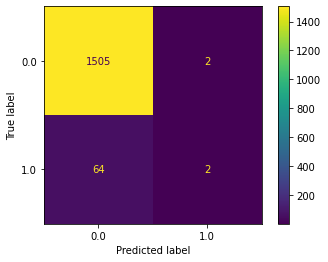

report:
              precision    recall  f1-score   support

     class 0       0.96      1.00      0.98      1507
     class 1       0.50      0.03      0.06        66

    accuracy                           0.96      1573
   macro avg       0.73      0.51      0.52      1573
weighted avg       0.94      0.96      0.94      1573



label  11


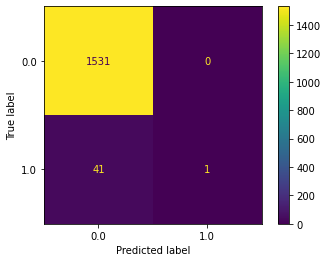

report:
              precision    recall  f1-score   support

     class 0       0.97      1.00      0.99      1531
     class 1       1.00      0.02      0.05        42

    accuracy                           0.97      1573
   macro avg       0.99      0.51      0.52      1573
weighted avg       0.97      0.97      0.96      1573



label  12


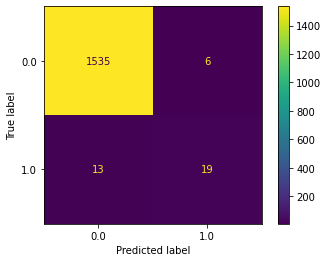

report:
              precision    recall  f1-score   support

     class 0       0.99      1.00      0.99      1541
     class 1       0.76      0.59      0.67        32

    accuracy                           0.99      1573
   macro avg       0.88      0.79      0.83      1573
weighted avg       0.99      0.99      0.99      1573



label  13


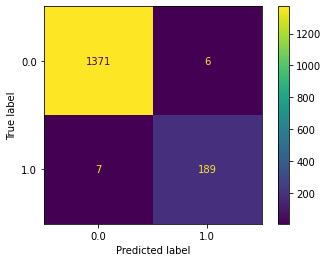

report:
              precision    recall  f1-score   support

     class 0       0.99      1.00      1.00      1377
     class 1       0.97      0.96      0.97       196

    accuracy                           0.99      1573
   macro avg       0.98      0.98      0.98      1573
weighted avg       0.99      0.99      0.99      1573



label  14


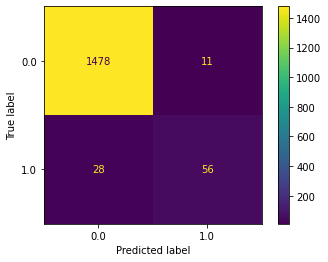

report:
              precision    recall  f1-score   support

     class 0       0.98      0.99      0.99      1489
     class 1       0.84      0.67      0.74        84

    accuracy                           0.98      1573
   macro avg       0.91      0.83      0.86      1573
weighted avg       0.97      0.98      0.97      1573



label  15


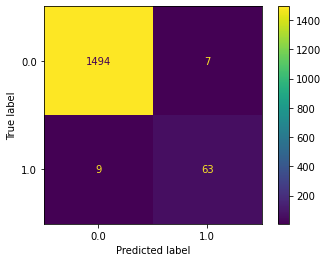

report:
              precision    recall  f1-score   support

     class 0       0.99      1.00      0.99      1501
     class 1       0.90      0.88      0.89        72

    accuracy                           0.99      1573
   macro avg       0.95      0.94      0.94      1573
weighted avg       0.99      0.99      0.99      1573



label  16


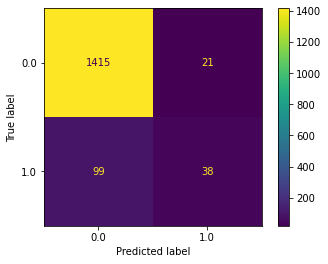

report:
              precision    recall  f1-score   support

     class 0       0.93      0.99      0.96      1436
     class 1       0.64      0.28      0.39       137

    accuracy                           0.92      1573
   macro avg       0.79      0.63      0.67      1573
weighted avg       0.91      0.92      0.91      1573



label  17


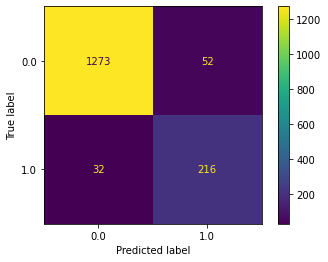

report:
              precision    recall  f1-score   support

     class 0       0.98      0.96      0.97      1325
     class 1       0.81      0.87      0.84       248

    accuracy                           0.95      1573
   macro avg       0.89      0.92      0.90      1573
weighted avg       0.95      0.95      0.95      1573



label  18


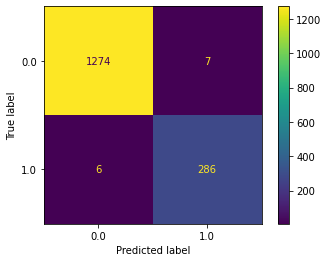

report:
              precision    recall  f1-score   support

     class 0       1.00      0.99      0.99      1281
     class 1       0.98      0.98      0.98       292

    accuracy                           0.99      1573
   macro avg       0.99      0.99      0.99      1573
weighted avg       0.99      0.99      0.99      1573



label  19


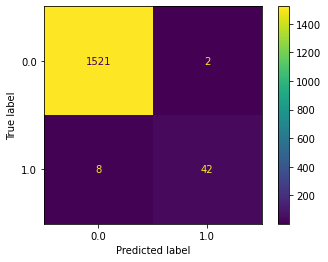

report:
              precision    recall  f1-score   support

     class 0       0.99      1.00      1.00      1523
     class 1       0.95      0.84      0.89        50

    accuracy                           0.99      1573
   macro avg       0.97      0.92      0.95      1573
weighted avg       0.99      0.99      0.99      1573



label  20


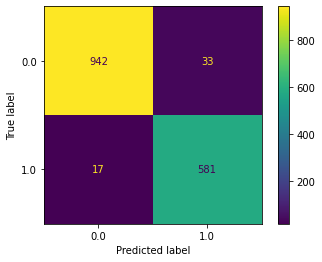

report:
              precision    recall  f1-score   support

     class 0       0.98      0.97      0.97       975
     class 1       0.95      0.97      0.96       598

    accuracy                           0.97      1573
   macro avg       0.96      0.97      0.97      1573
weighted avg       0.97      0.97      0.97      1573



label  21


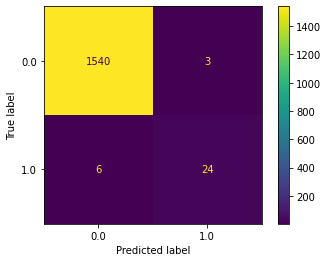

report:
              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00      1543
     class 1       0.89      0.80      0.84        30

    accuracy                           0.99      1573
   macro avg       0.94      0.90      0.92      1573
weighted avg       0.99      0.99      0.99      1573



label  22


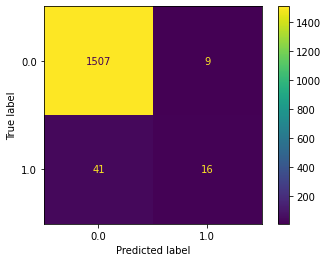

report:
              precision    recall  f1-score   support

     class 0       0.97      0.99      0.98      1516
     class 1       0.64      0.28      0.39        57

    accuracy                           0.97      1573
   macro avg       0.81      0.64      0.69      1573
weighted avg       0.96      0.97      0.96      1573



label  23


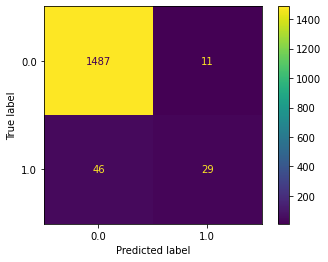

report:
              precision    recall  f1-score   support

     class 0       0.97      0.99      0.98      1498
     class 1       0.72      0.39      0.50        75

    accuracy                           0.96      1573
   macro avg       0.85      0.69      0.74      1573
weighted avg       0.96      0.96      0.96      1573



label  24


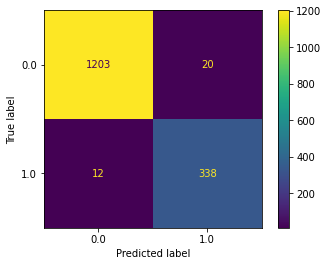

report:
              precision    recall  f1-score   support

     class 0       0.99      0.98      0.99      1223
     class 1       0.94      0.97      0.95       350

    accuracy                           0.98      1573
   macro avg       0.97      0.97      0.97      1573
weighted avg       0.98      0.98      0.98      1573



label  25


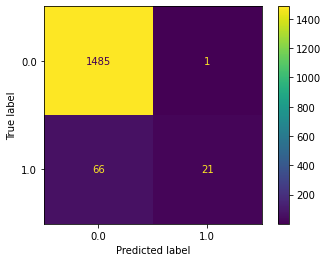

report:
              precision    recall  f1-score   support

     class 0       0.96      1.00      0.98      1486
     class 1       0.95      0.24      0.39        87

    accuracy                           0.96      1573
   macro avg       0.96      0.62      0.68      1573
weighted avg       0.96      0.96      0.95      1573



label  26


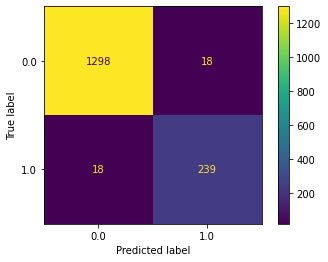

report:
              precision    recall  f1-score   support

     class 0       0.99      0.99      0.99      1316
     class 1       0.93      0.93      0.93       257

    accuracy                           0.98      1573
   macro avg       0.96      0.96      0.96      1573
weighted avg       0.98      0.98      0.98      1573



label  27


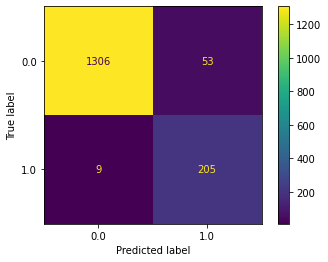

report:
              precision    recall  f1-score   support

     class 0       0.99      0.96      0.98      1359
     class 1       0.79      0.96      0.87       214

    accuracy                           0.96      1573
   macro avg       0.89      0.96      0.92      1573
weighted avg       0.97      0.96      0.96      1573



label  28


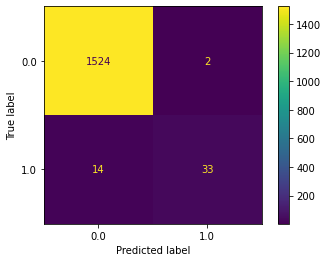

report:
              precision    recall  f1-score   support

     class 0       0.99      1.00      0.99      1526
     class 1       0.94      0.70      0.80        47

    accuracy                           0.99      1573
   macro avg       0.97      0.85      0.90      1573
weighted avg       0.99      0.99      0.99      1573



label  29


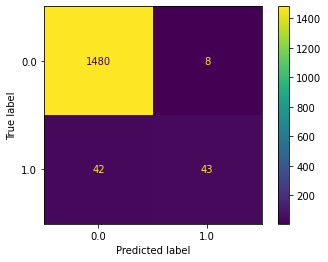

report:
              precision    recall  f1-score   support

     class 0       0.97      0.99      0.98      1488
     class 1       0.84      0.51      0.63        85

    accuracy                           0.97      1573
   macro avg       0.91      0.75      0.81      1573
weighted avg       0.97      0.97      0.96      1573



label  30


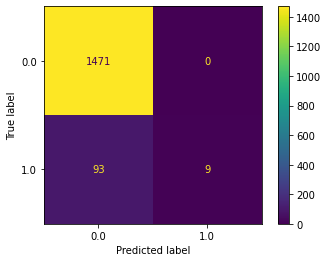

report:
              precision    recall  f1-score   support

     class 0       0.94      1.00      0.97      1471
     class 1       1.00      0.09      0.16       102

    accuracy                           0.94      1573
   macro avg       0.97      0.54      0.57      1573
weighted avg       0.94      0.94      0.92      1573



label  31


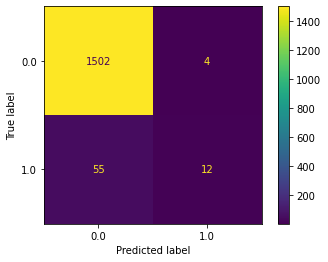

report:
              precision    recall  f1-score   support

     class 0       0.96      1.00      0.98      1506
     class 1       0.75      0.18      0.29        67

    accuracy                           0.96      1573
   macro avg       0.86      0.59      0.63      1573
weighted avg       0.96      0.96      0.95      1573



label  32


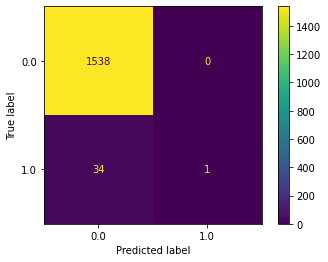

report:
              precision    recall  f1-score   support

     class 0       0.98      1.00      0.99      1538
     class 1       1.00      0.03      0.06        35

    accuracy                           0.98      1573
   macro avg       0.99      0.51      0.52      1573
weighted avg       0.98      0.98      0.97      1573



label  33


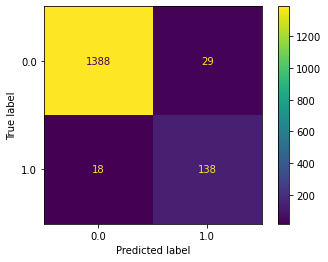

report:
              precision    recall  f1-score   support

     class 0       0.99      0.98      0.98      1417
     class 1       0.83      0.88      0.85       156

    accuracy                           0.97      1573
   macro avg       0.91      0.93      0.92      1573
weighted avg       0.97      0.97      0.97      1573



label  34


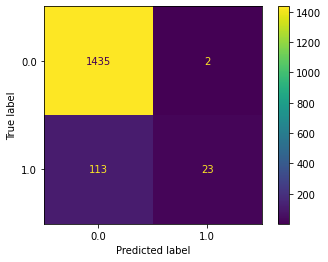

report:
              precision    recall  f1-score   support

     class 0       0.93      1.00      0.96      1437
     class 1       0.92      0.17      0.29       136

    accuracy                           0.93      1573
   macro avg       0.92      0.58      0.62      1573
weighted avg       0.93      0.93      0.90      1573



label  35


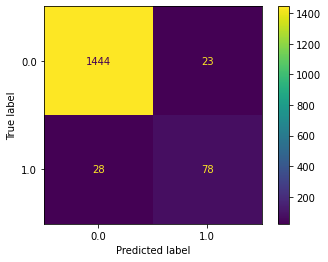

report:
              precision    recall  f1-score   support

     class 0       0.98      0.98      0.98      1467
     class 1       0.77      0.74      0.75       106

    accuracy                           0.97      1573
   macro avg       0.88      0.86      0.87      1573
weighted avg       0.97      0.97      0.97      1573



label  36


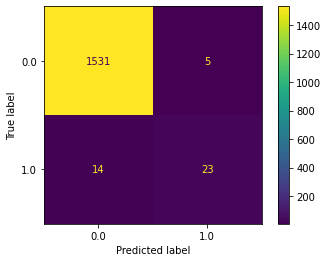

report:
              precision    recall  f1-score   support

     class 0       0.99      1.00      0.99      1536
     class 1       0.82      0.62      0.71        37

    accuracy                           0.99      1573
   macro avg       0.91      0.81      0.85      1573
weighted avg       0.99      0.99      0.99      1573



label  37


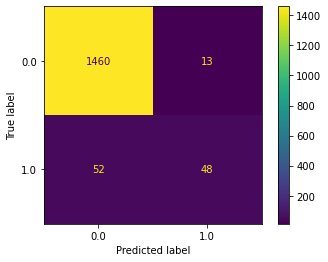

report:
              precision    recall  f1-score   support

     class 0       0.97      0.99      0.98      1473
     class 1       0.79      0.48      0.60       100

    accuracy                           0.96      1573
   macro avg       0.88      0.74      0.79      1573
weighted avg       0.95      0.96      0.95      1573



label  38


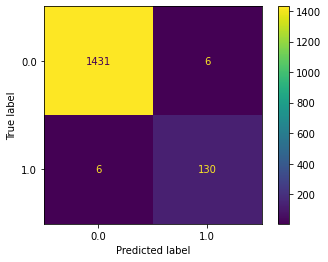

report:
              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00      1437
     class 1       0.96      0.96      0.96       136

    accuracy                           0.99      1573
   macro avg       0.98      0.98      0.98      1573
weighted avg       0.99      0.99      0.99      1573



label  39


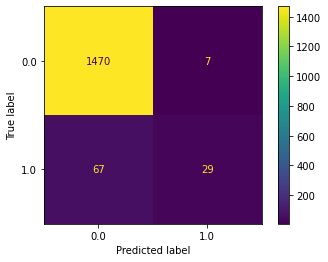

report:
              precision    recall  f1-score   support

     class 0       0.96      1.00      0.98      1477
     class 1       0.81      0.30      0.44        96

    accuracy                           0.95      1573
   macro avg       0.88      0.65      0.71      1573
weighted avg       0.95      0.95      0.94      1573



label  40


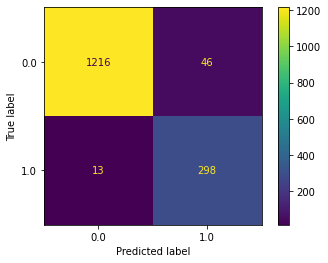

report:
              precision    recall  f1-score   support

     class 0       0.99      0.96      0.98      1262
     class 1       0.87      0.96      0.91       311

    accuracy                           0.96      1573
   macro avg       0.93      0.96      0.94      1573
weighted avg       0.97      0.96      0.96      1573



label  41


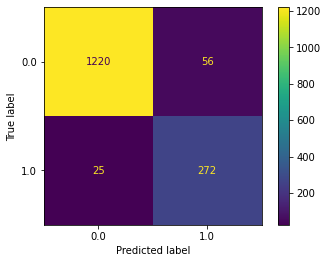

report:
              precision    recall  f1-score   support

     class 0       0.98      0.96      0.97      1276
     class 1       0.83      0.92      0.87       297

    accuracy                           0.95      1573
   macro avg       0.90      0.94      0.92      1573
weighted avg       0.95      0.95      0.95      1573



label  42


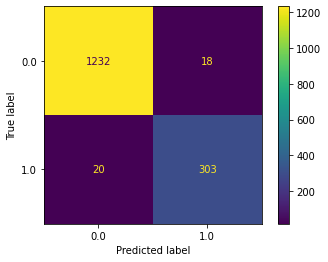

report:
              precision    recall  f1-score   support

     class 0       0.98      0.99      0.98      1250
     class 1       0.94      0.94      0.94       323

    accuracy                           0.98      1573
   macro avg       0.96      0.96      0.96      1573
weighted avg       0.98      0.98      0.98      1573



label  43


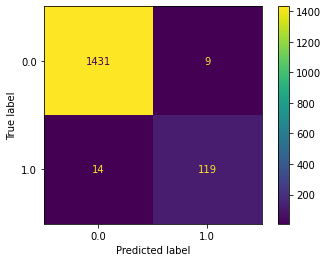

report:
              precision    recall  f1-score   support

     class 0       0.99      0.99      0.99      1440
     class 1       0.93      0.89      0.91       133

    accuracy                           0.99      1573
   macro avg       0.96      0.94      0.95      1573
weighted avg       0.99      0.99      0.99      1573



label  44


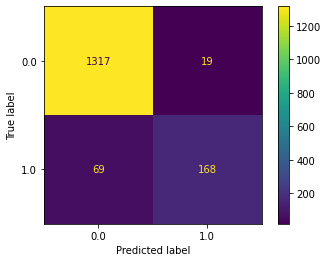

report:
              precision    recall  f1-score   support

     class 0       0.95      0.99      0.97      1336
     class 1       0.90      0.71      0.79       237

    accuracy                           0.94      1573
   macro avg       0.92      0.85      0.88      1573
weighted avg       0.94      0.94      0.94      1573



label  45


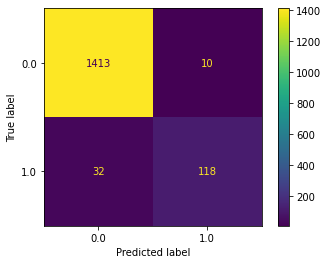

report:
              precision    recall  f1-score   support

     class 0       0.98      0.99      0.99      1423
     class 1       0.92      0.79      0.85       150

    accuracy                           0.97      1573
   macro avg       0.95      0.89      0.92      1573
weighted avg       0.97      0.97      0.97      1573



label  46


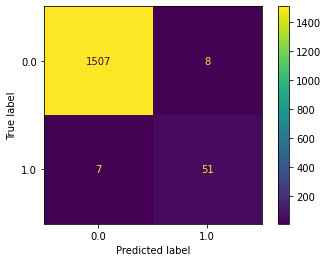

report:
              precision    recall  f1-score   support

     class 0       1.00      0.99      1.00      1515
     class 1       0.86      0.88      0.87        58

    accuracy                           0.99      1573
   macro avg       0.93      0.94      0.93      1573
weighted avg       0.99      0.99      0.99      1573



label  47


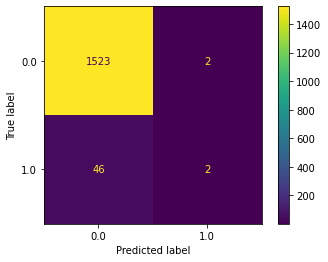

report:
              precision    recall  f1-score   support

     class 0       0.97      1.00      0.98      1525
     class 1       0.50      0.04      0.08        48

    accuracy                           0.97      1573
   macro avg       0.74      0.52      0.53      1573
weighted avg       0.96      0.97      0.96      1573



label  48


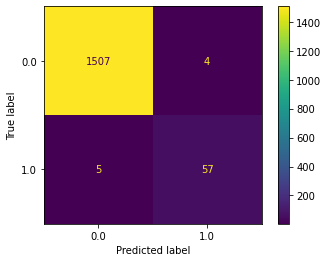

report:
              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00      1511
     class 1       0.93      0.92      0.93        62

    accuracy                           0.99      1573
   macro avg       0.97      0.96      0.96      1573
weighted avg       0.99      0.99      0.99      1573



label  49


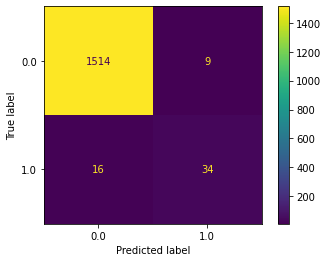

report:
              precision    recall  f1-score   support

     class 0       0.99      0.99      0.99      1523
     class 1       0.79      0.68      0.73        50

    accuracy                           0.98      1573
   macro avg       0.89      0.84      0.86      1573
weighted avg       0.98      0.98      0.98      1573





In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
for i in range(0,50):
  print('label ',i)
  y_true = val_targets[:,i]
  y_pred = val_prediction[:,i]

  # 混淆矩阵
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
  plt.show()
  #print(confusion_matrix(y_true, y_pred))

  # precision,recall,f1
  target_names = ['class 0', 'class 1']
  print('report:')
  print(classification_report(y_true, y_pred, target_names=target_names))
  print()
  print()


Below is label 0


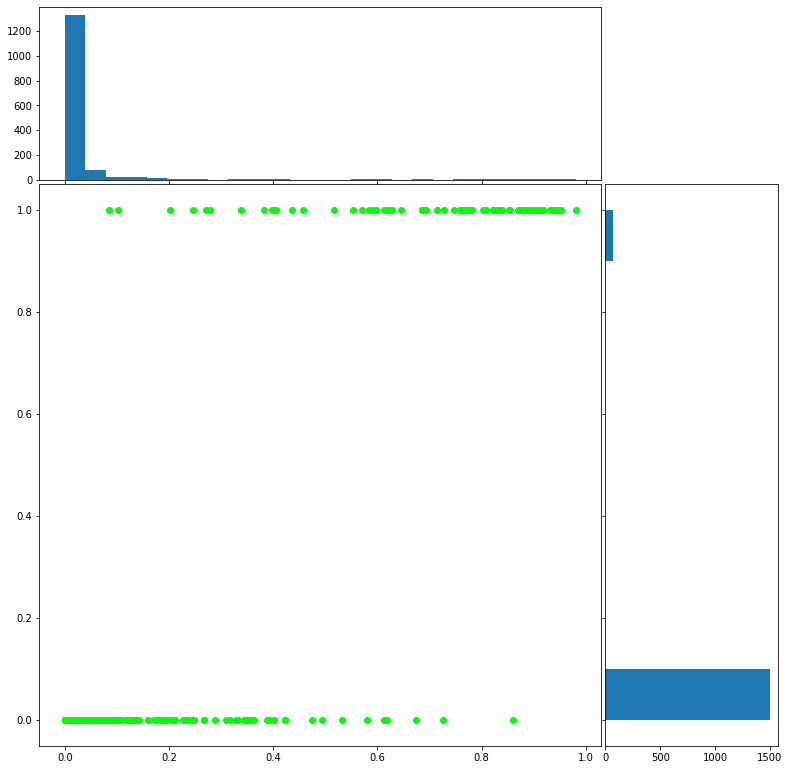


Below is label 1


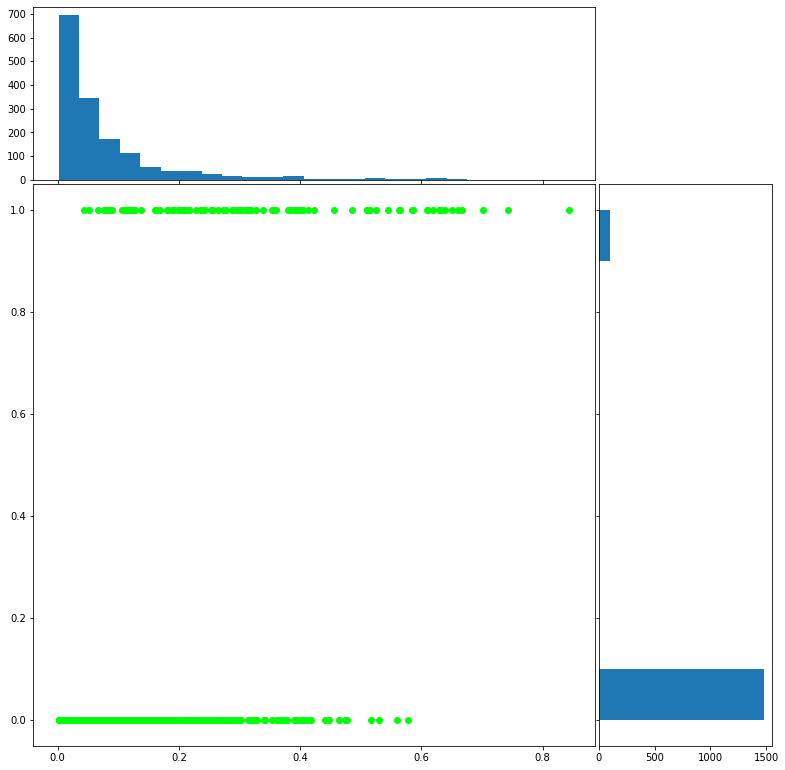


Below is label 2


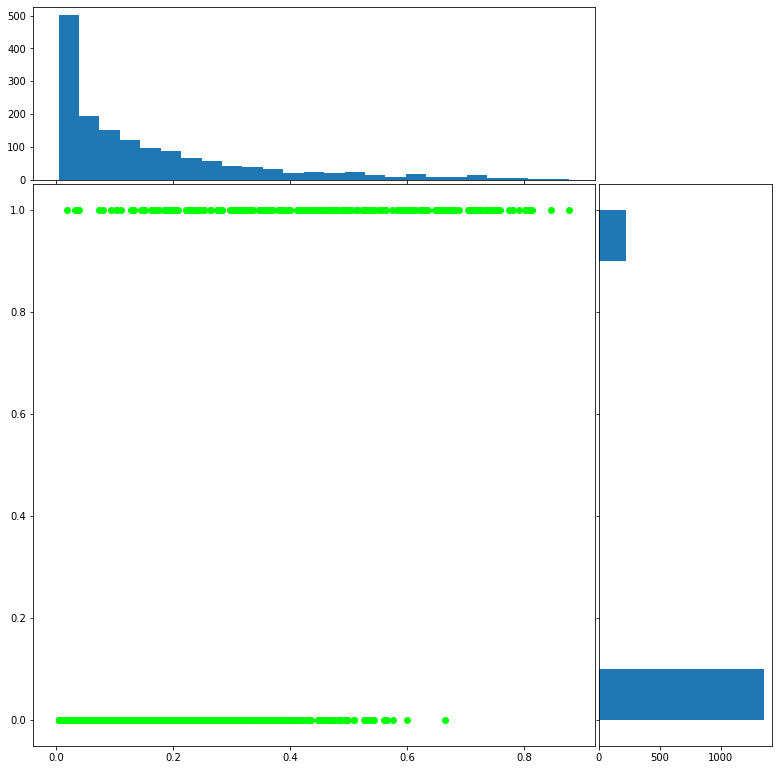


Below is label 3


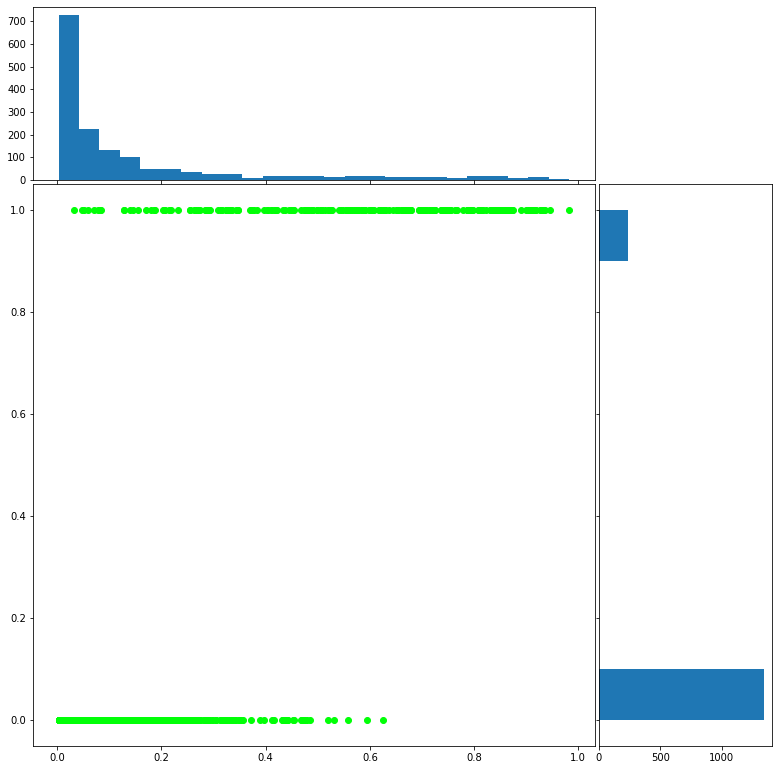


Below is label 4


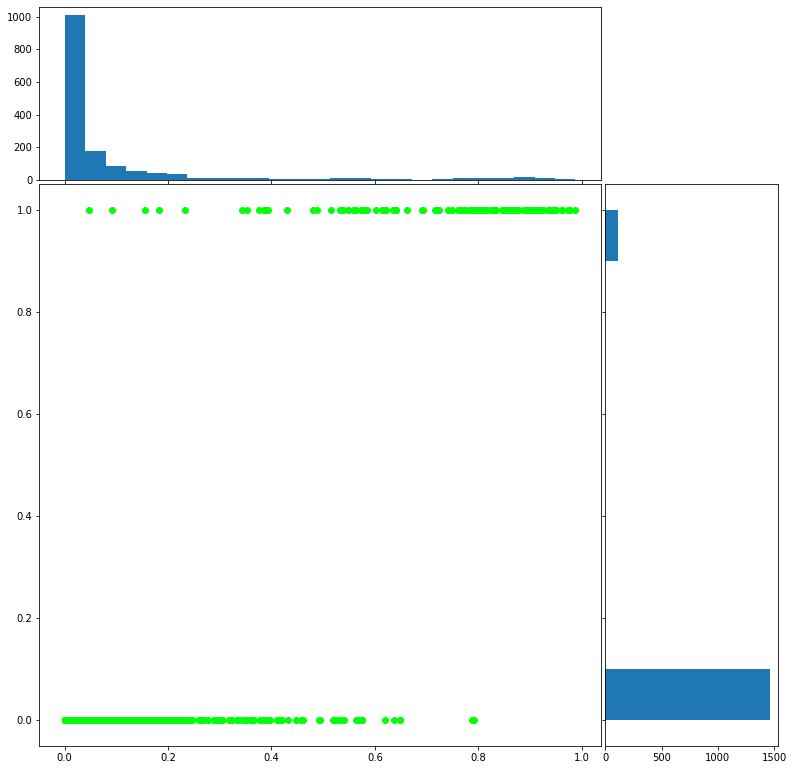


Below is label 5


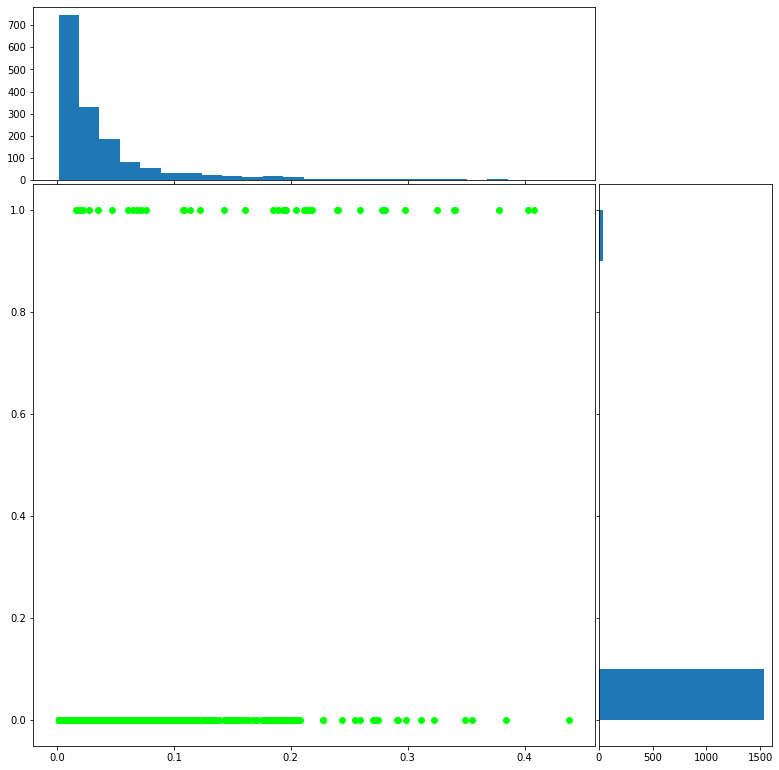


Below is label 6


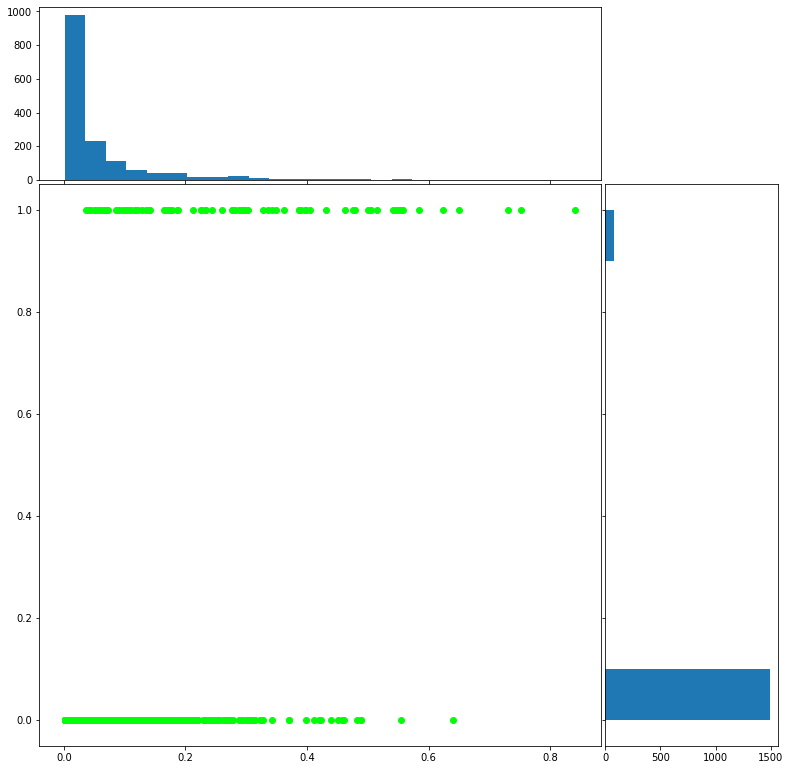


Below is label 7


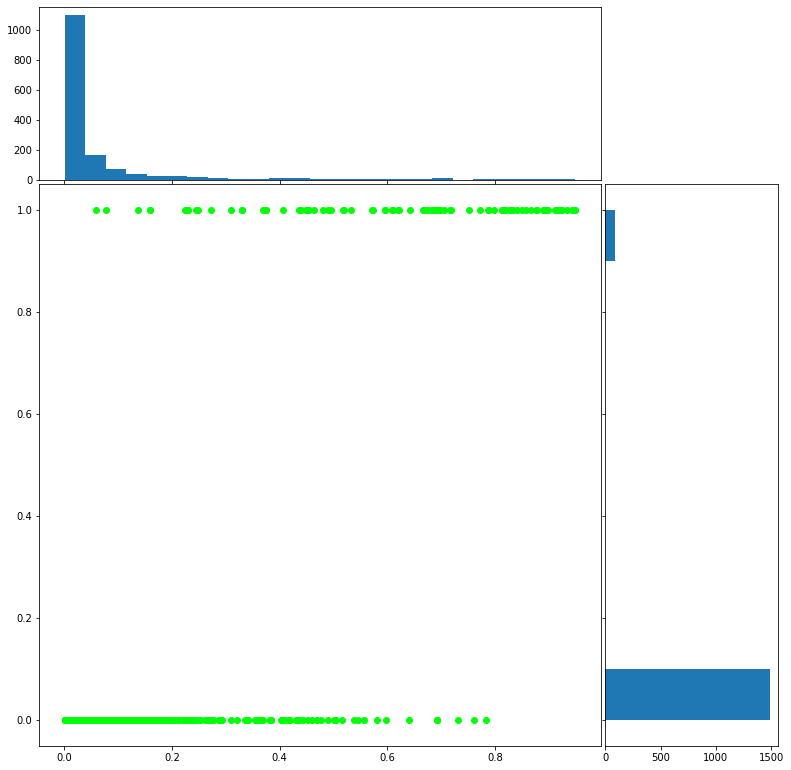


Below is label 8


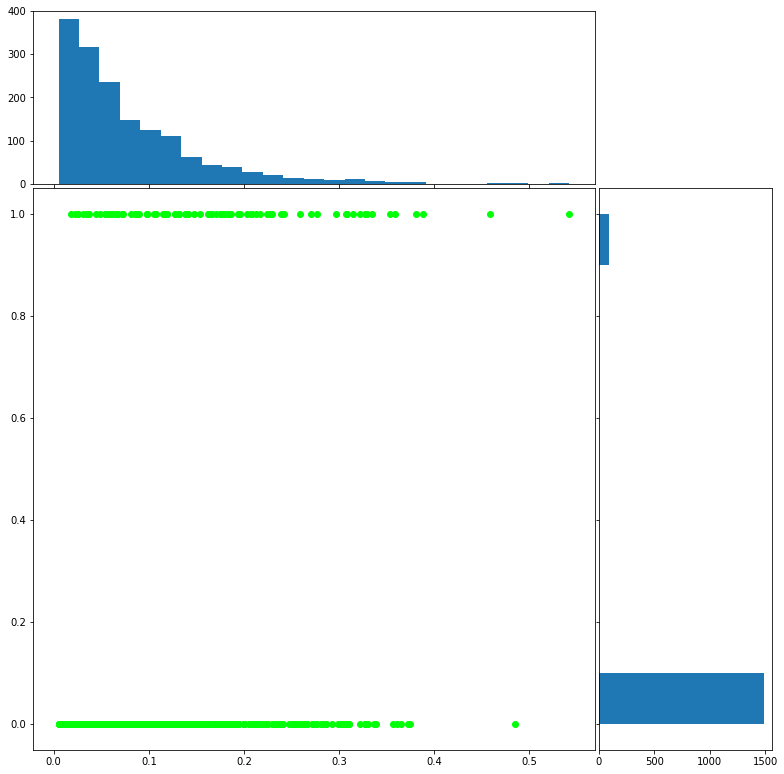


Below is label 9


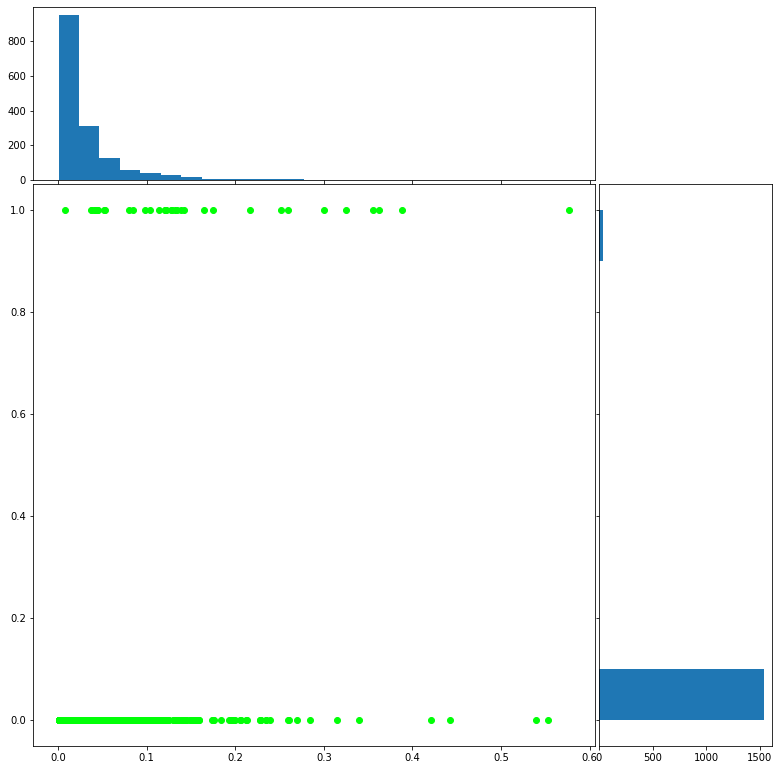


Below is label 10


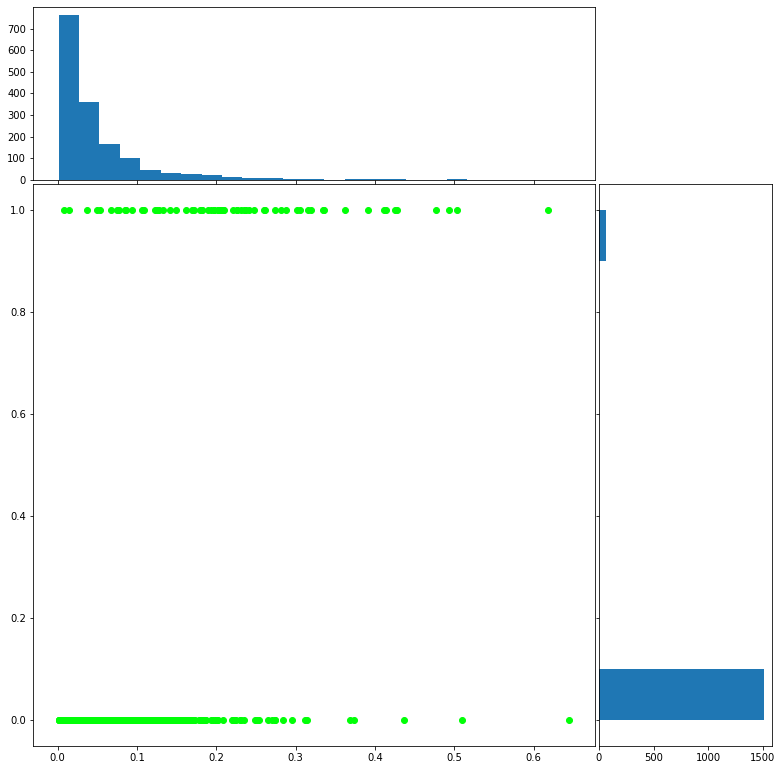


Below is label 11


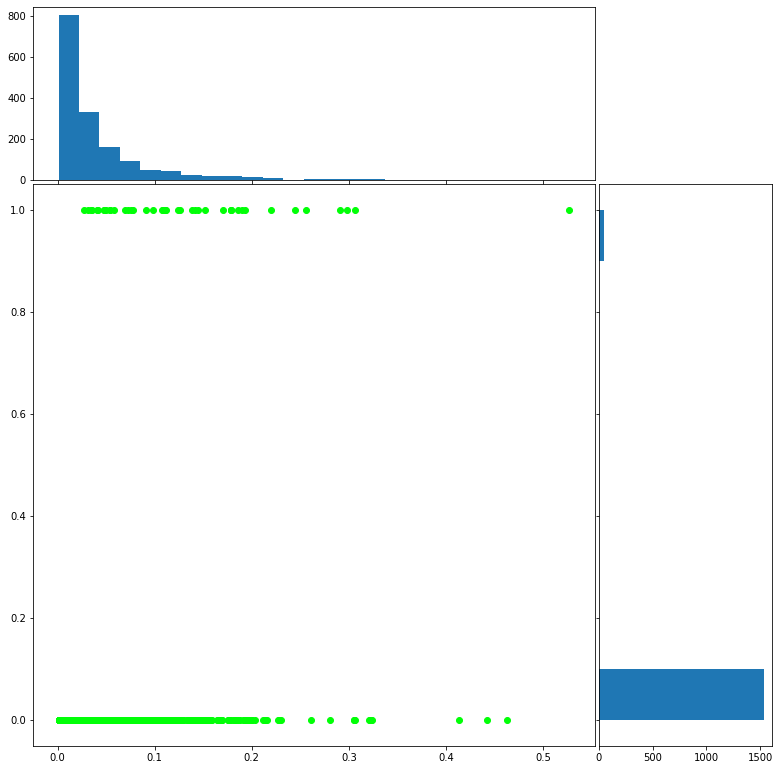


Below is label 12


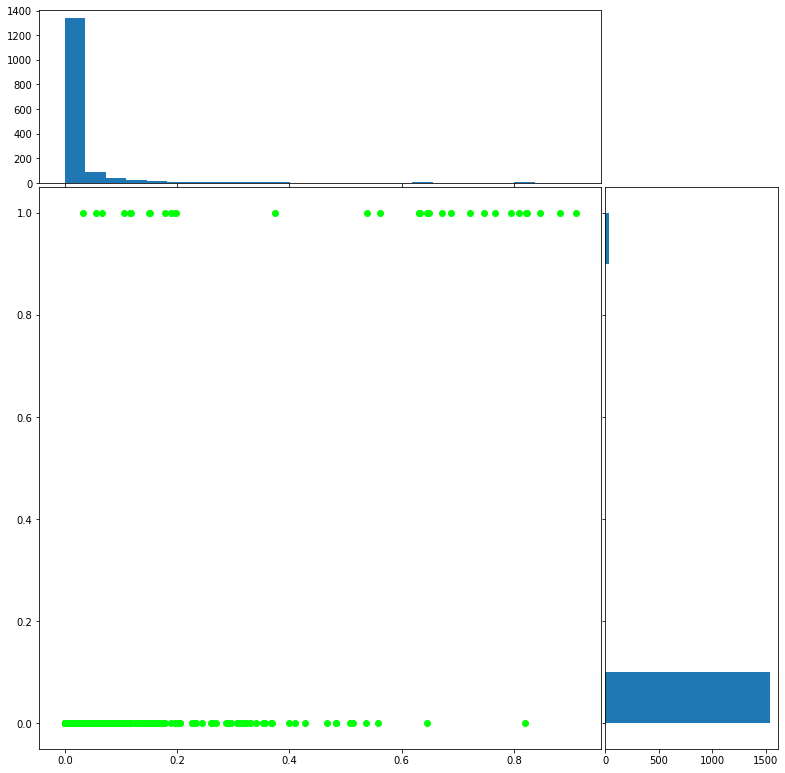


Below is label 13


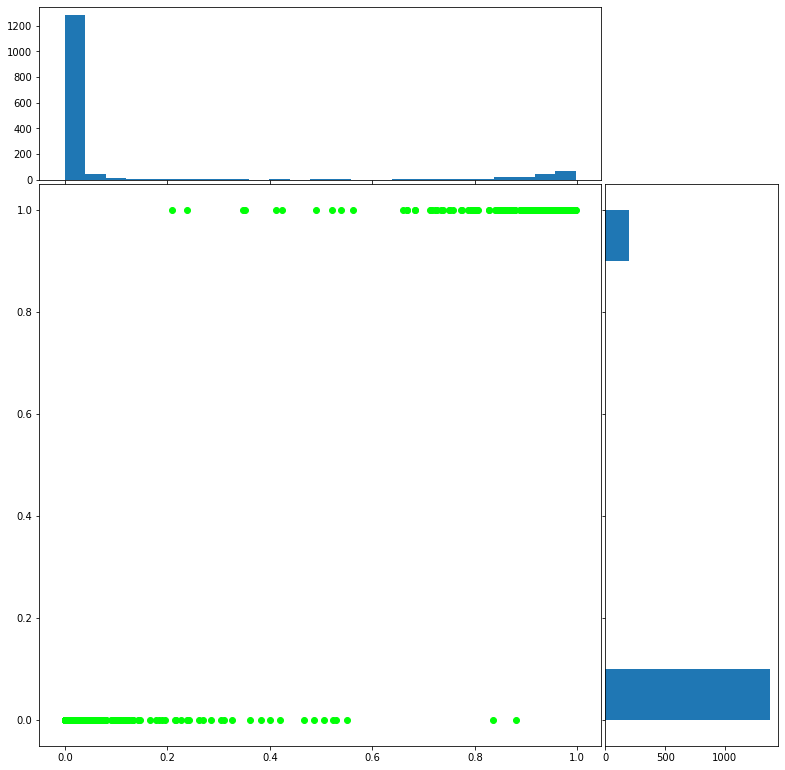


Below is label 14


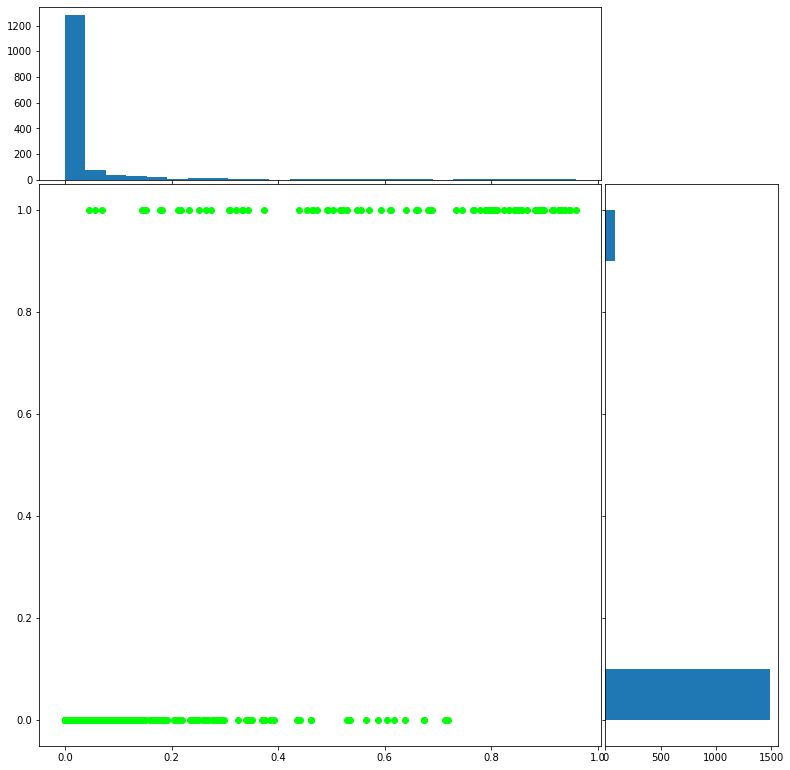


Below is label 15


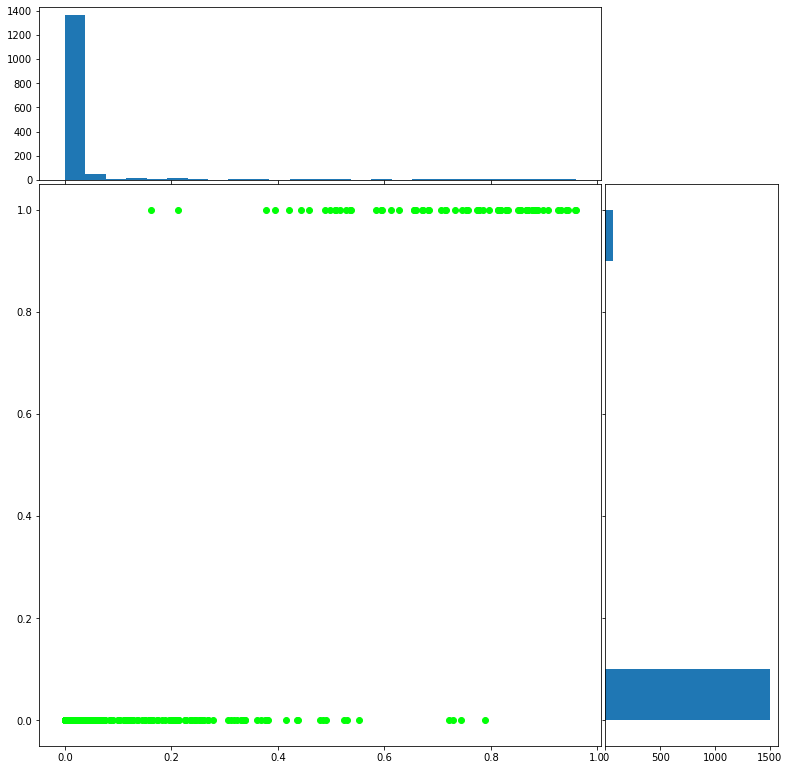


Below is label 16


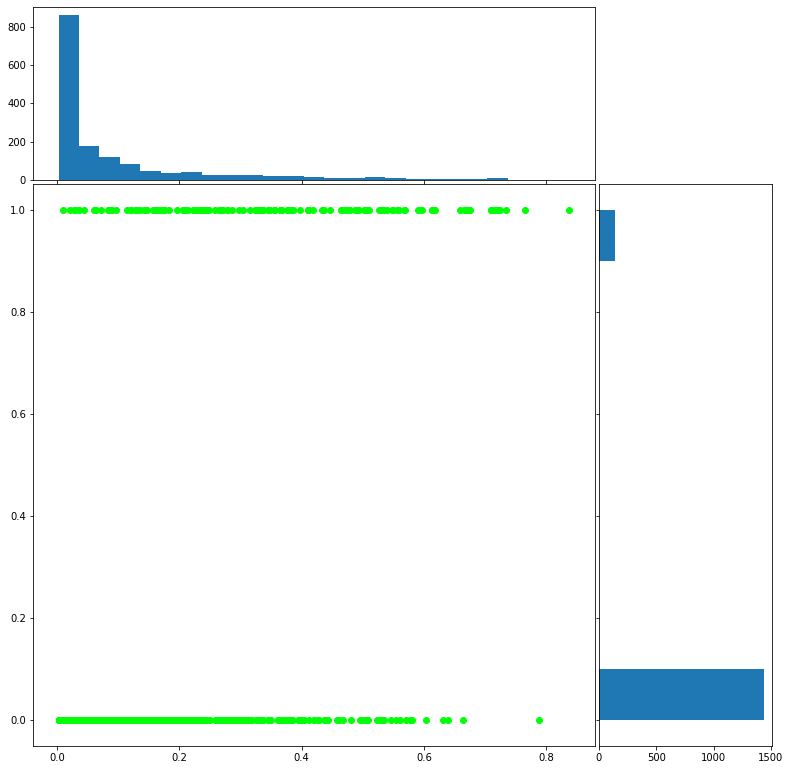


Below is label 17


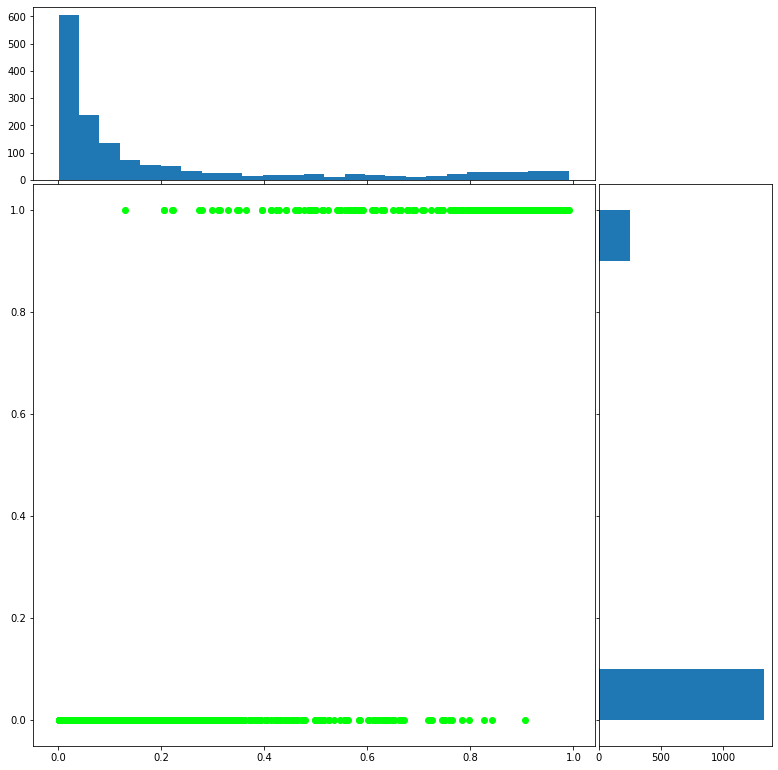


Below is label 18


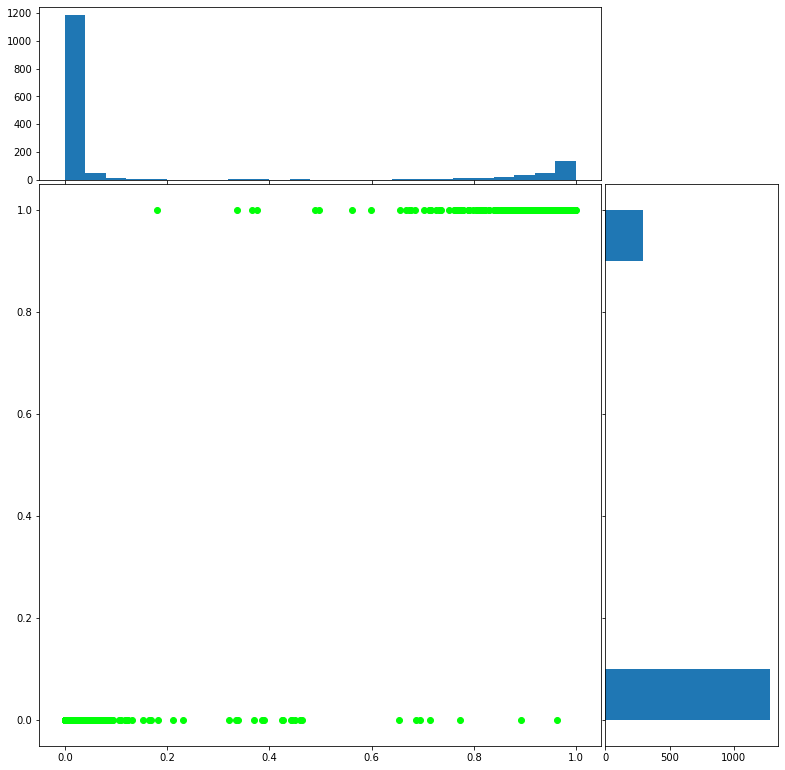


Below is label 19


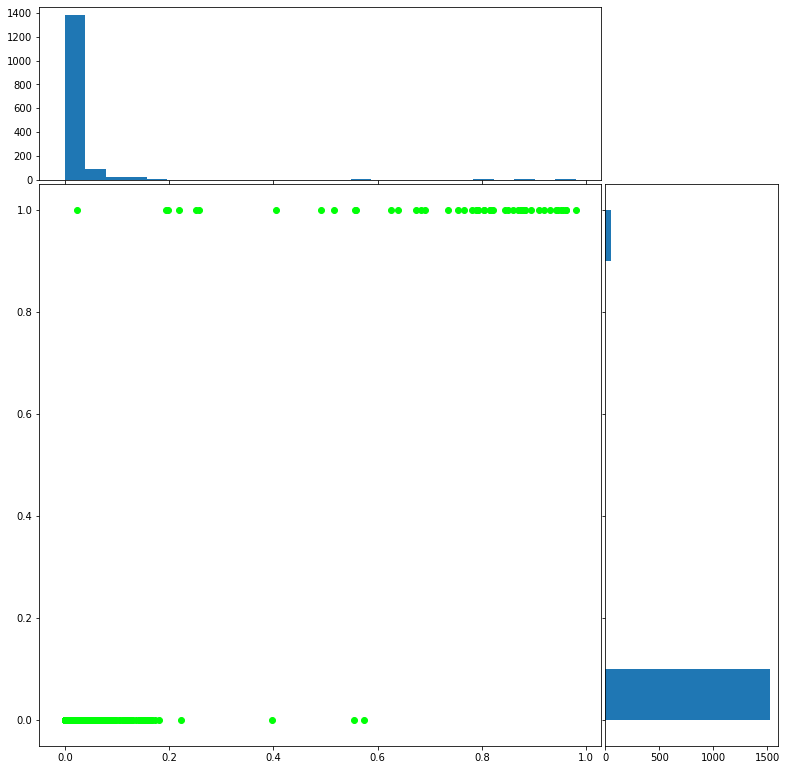


Below is label 20


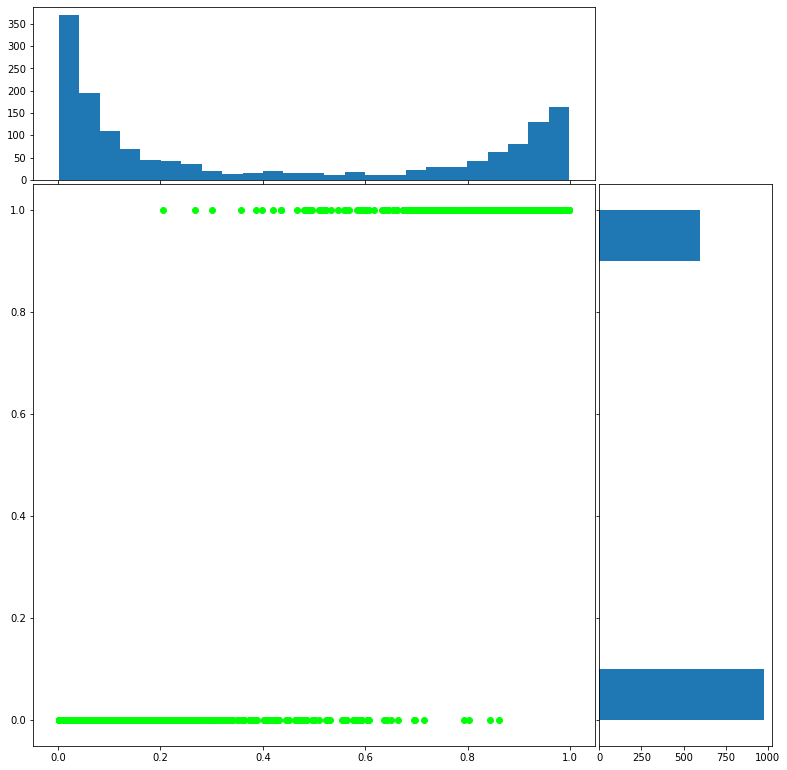


Below is label 21


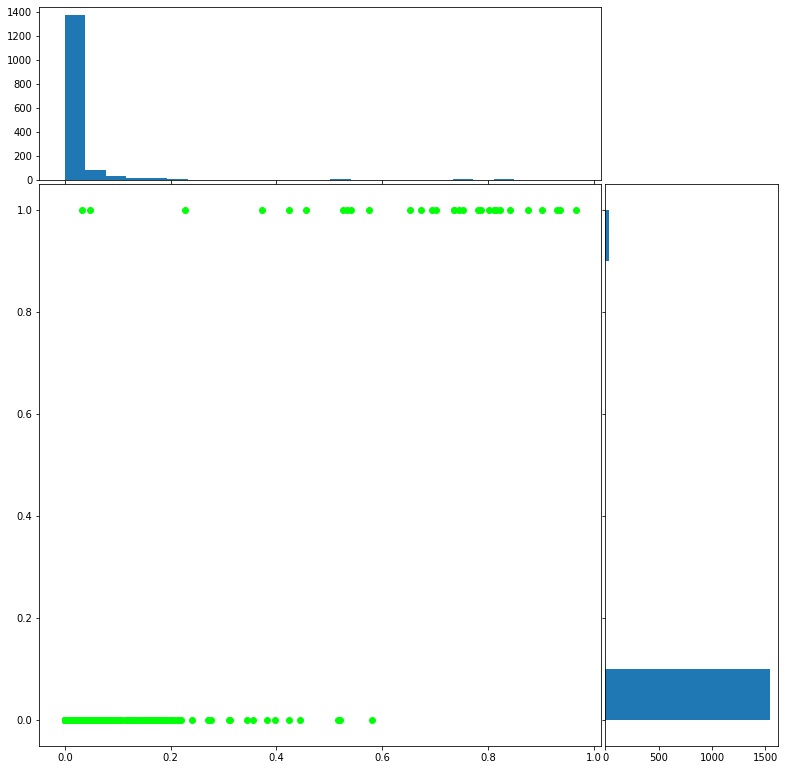


Below is label 22


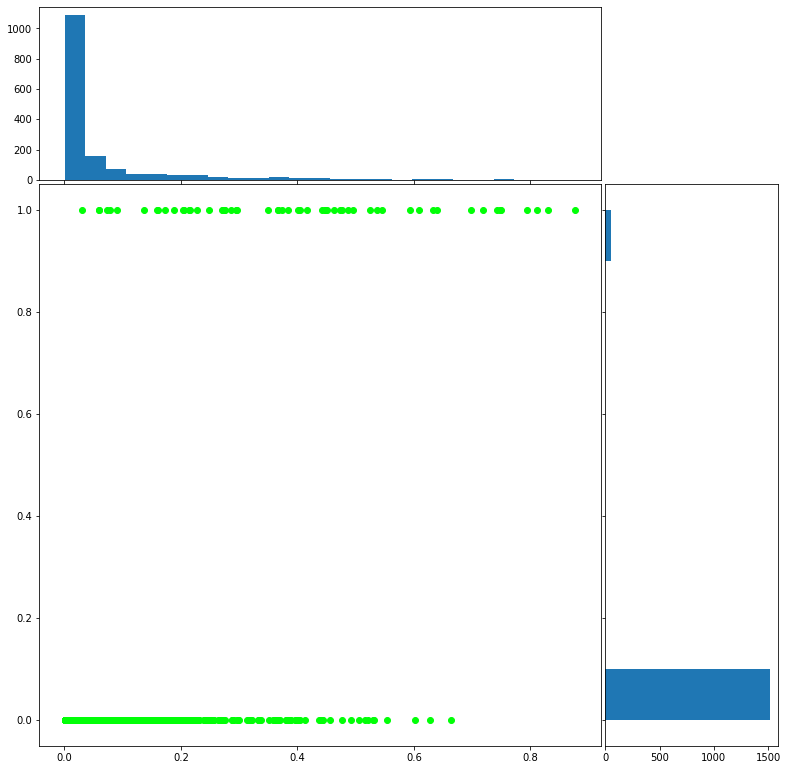


Below is label 23


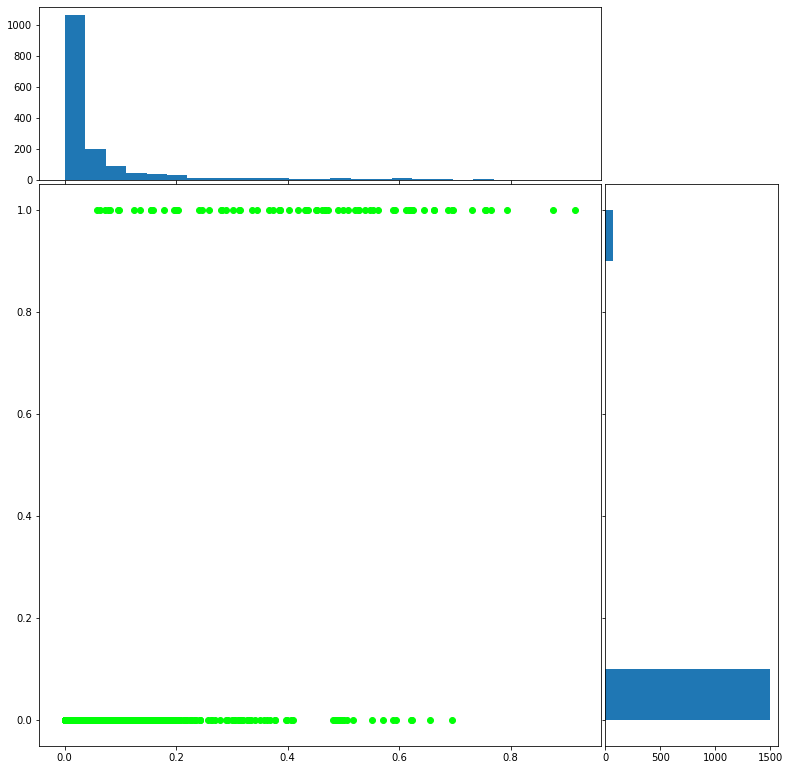


Below is label 24


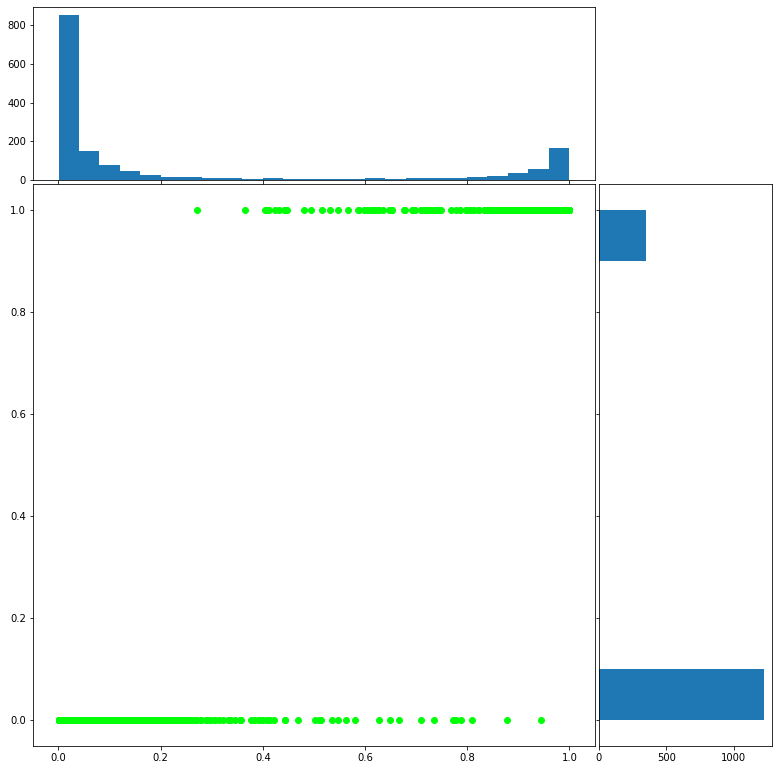


Below is label 25


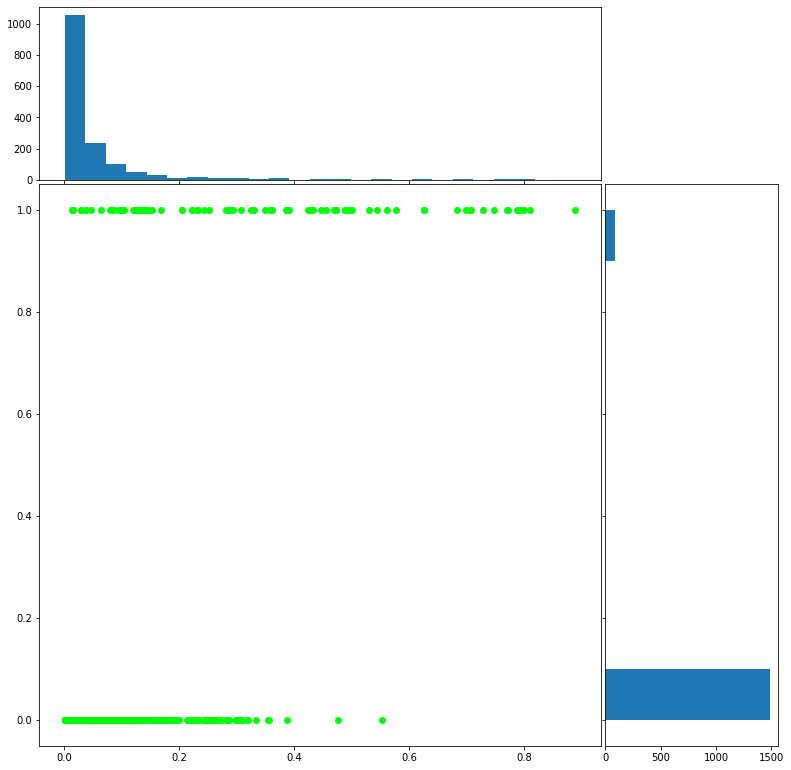


Below is label 26


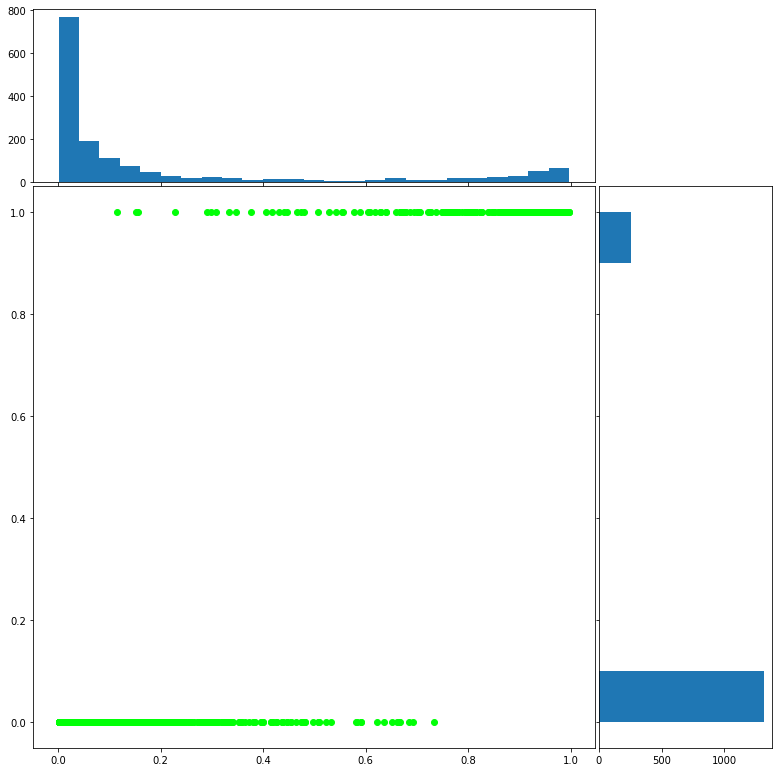


Below is label 27


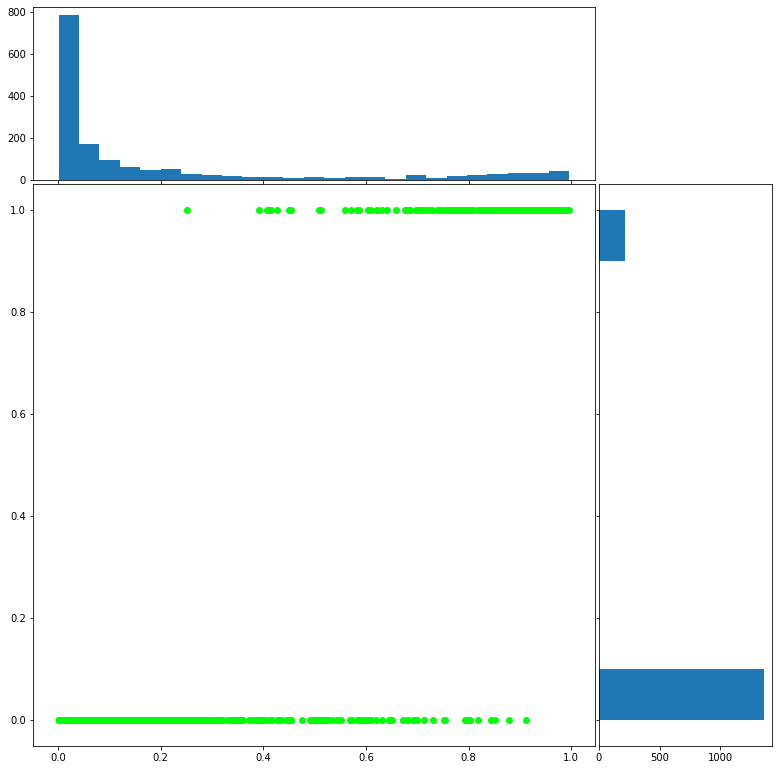


Below is label 28


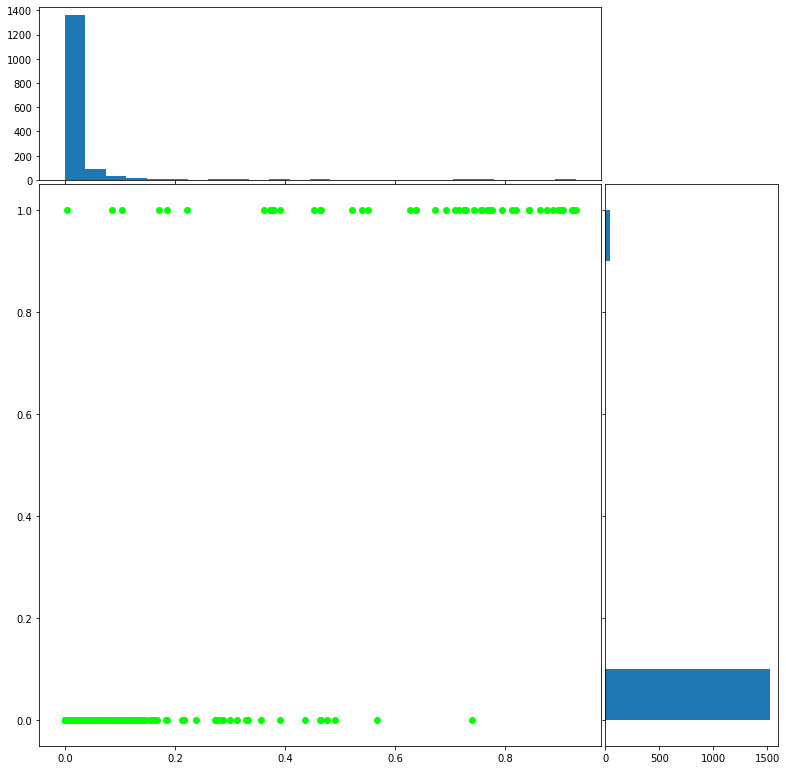


Below is label 29


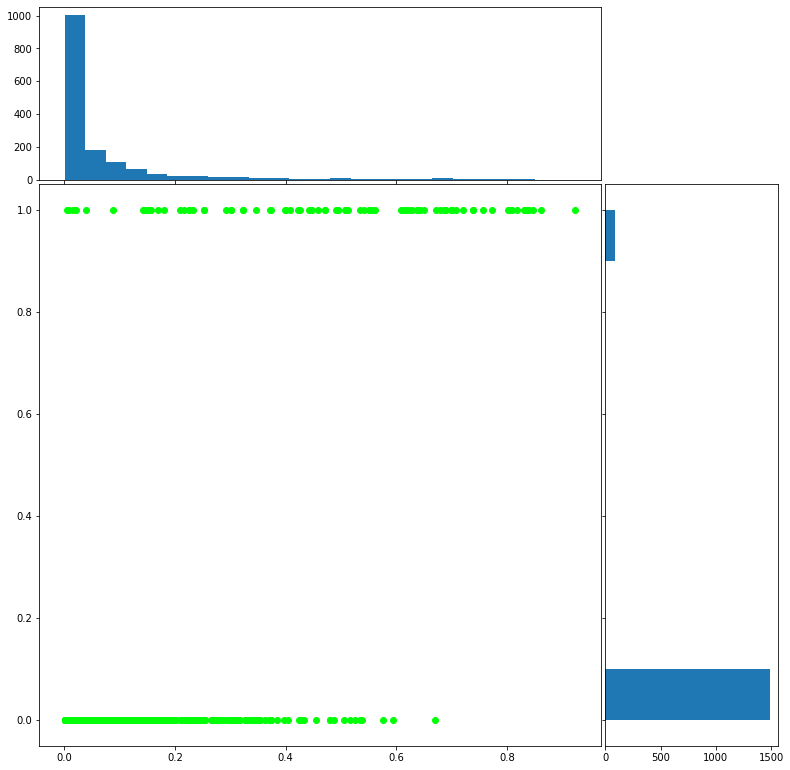


Below is label 30


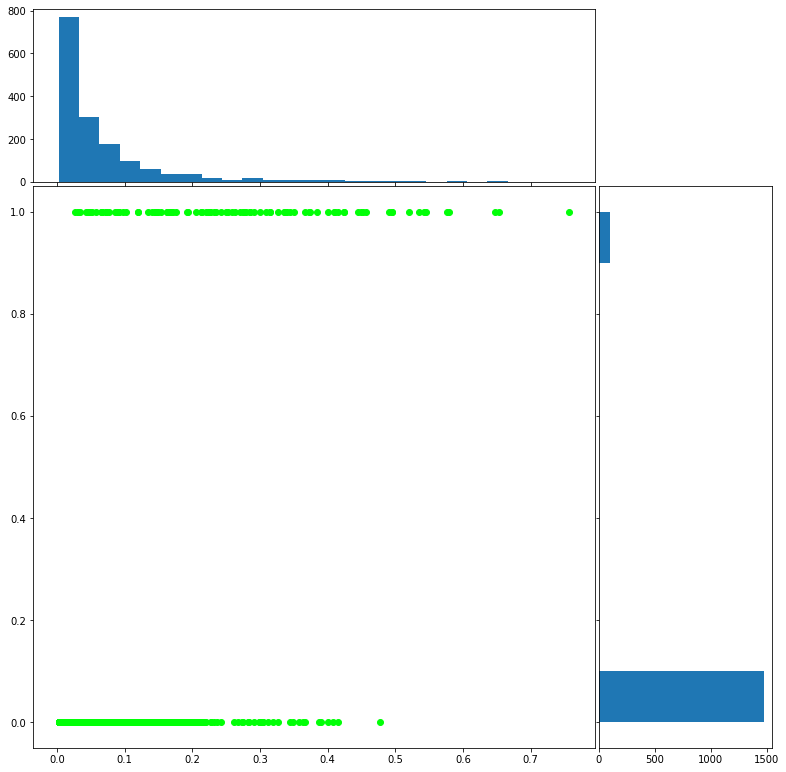


Below is label 31


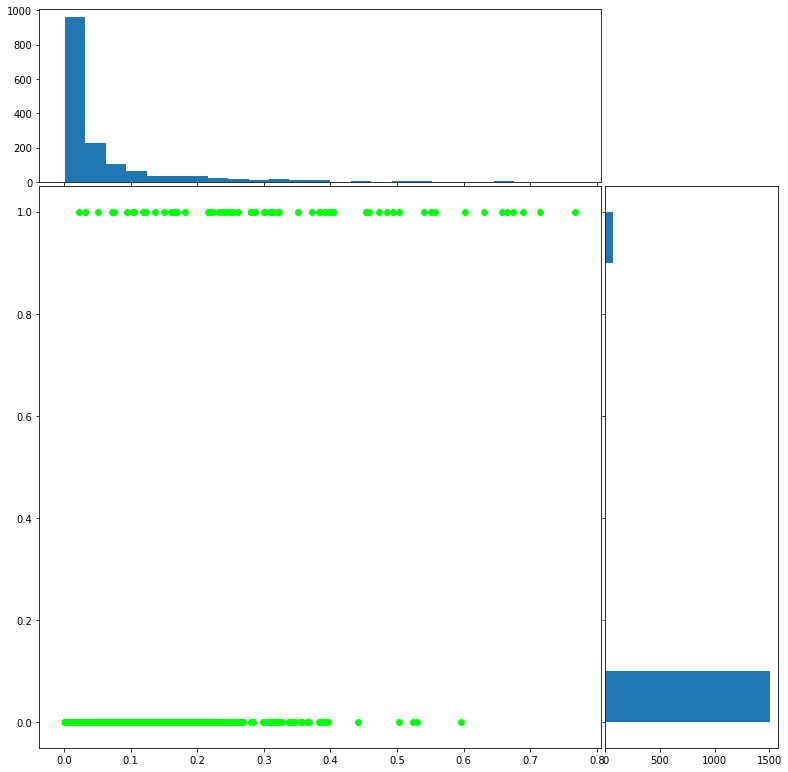


Below is label 32


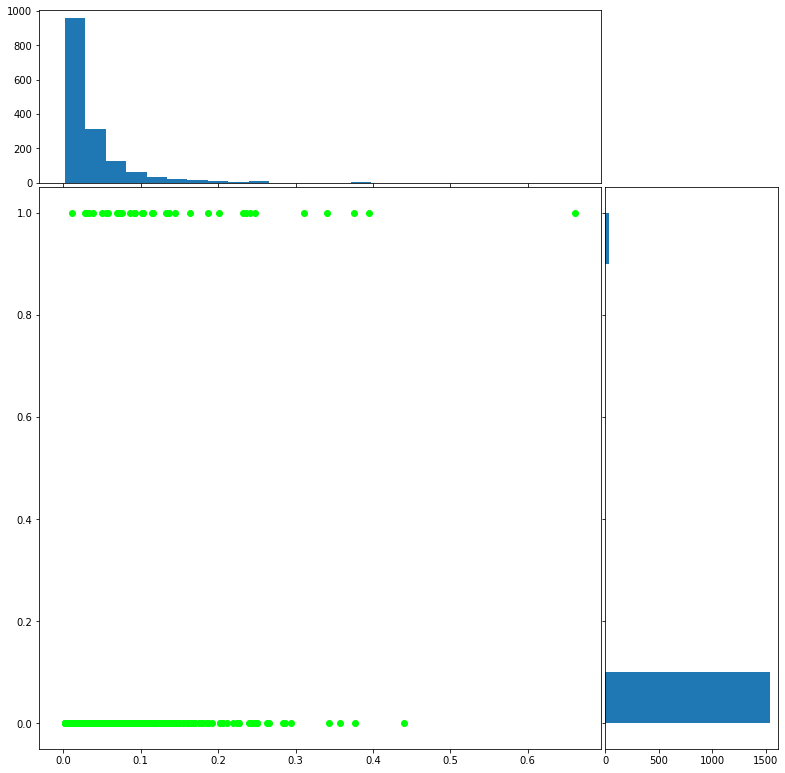


Below is label 33


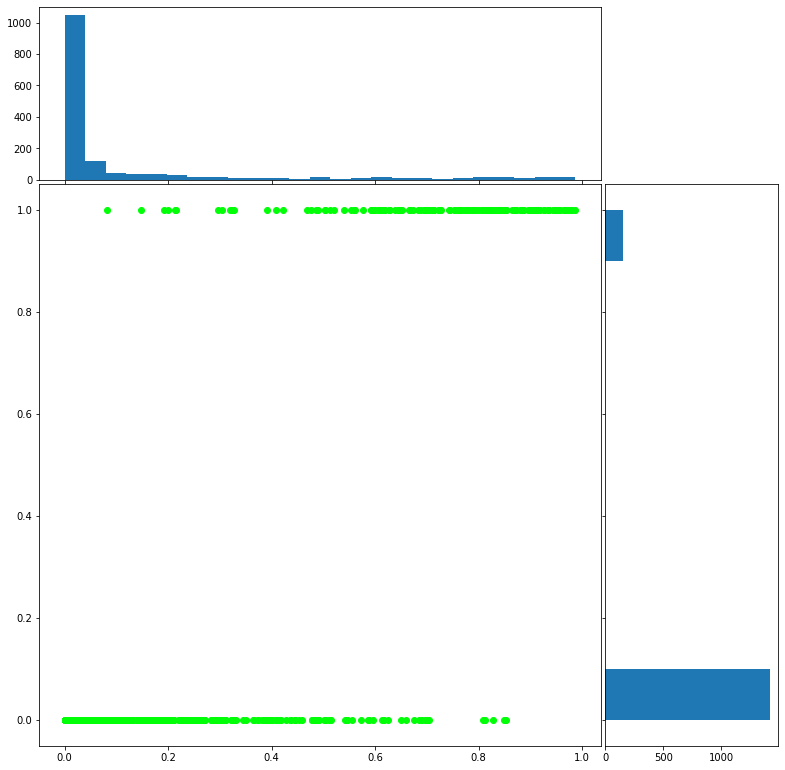


Below is label 34


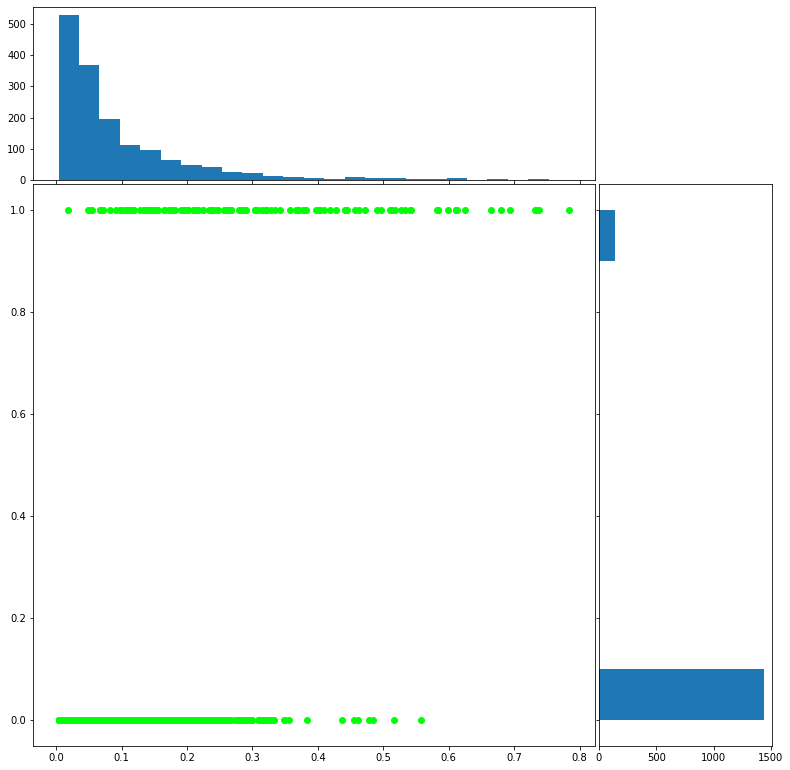


Below is label 35


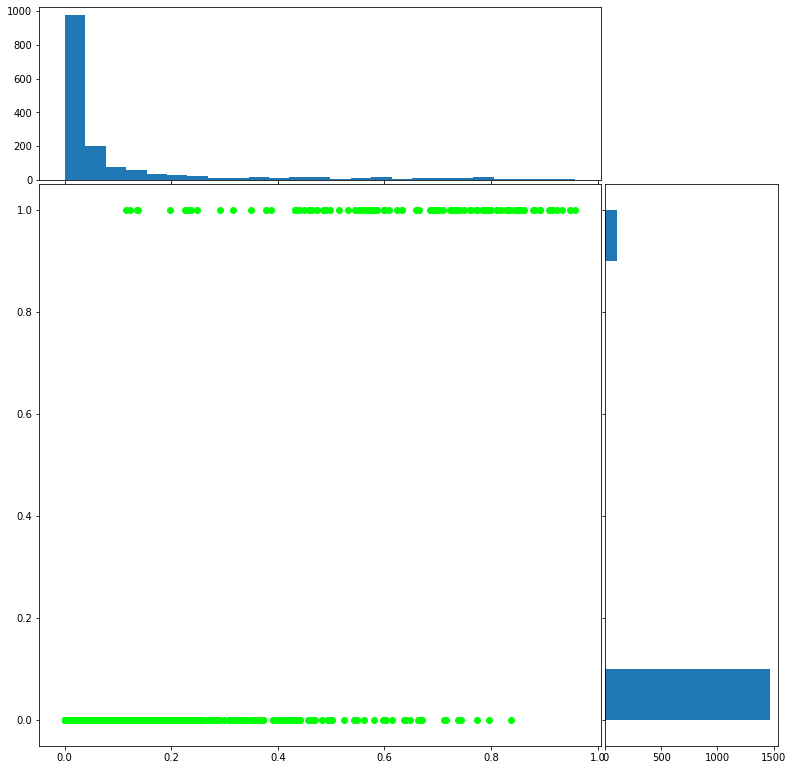


Below is label 36


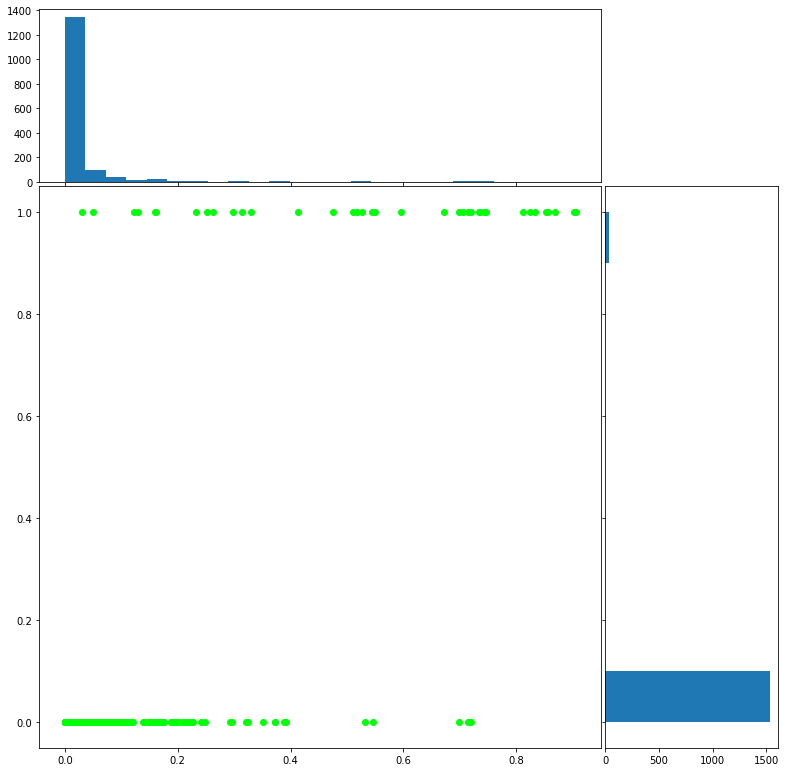


Below is label 37


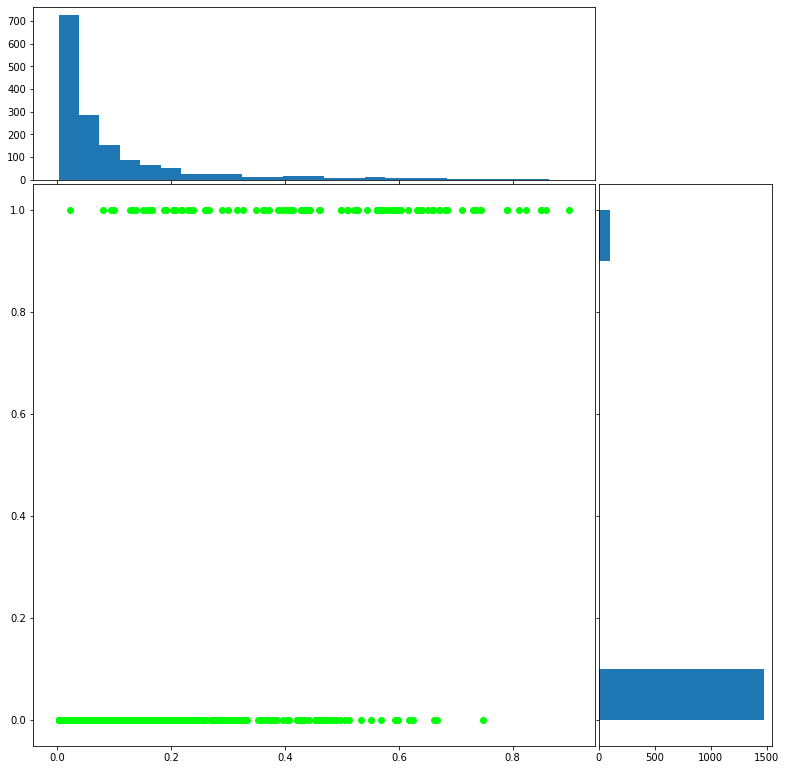


Below is label 38


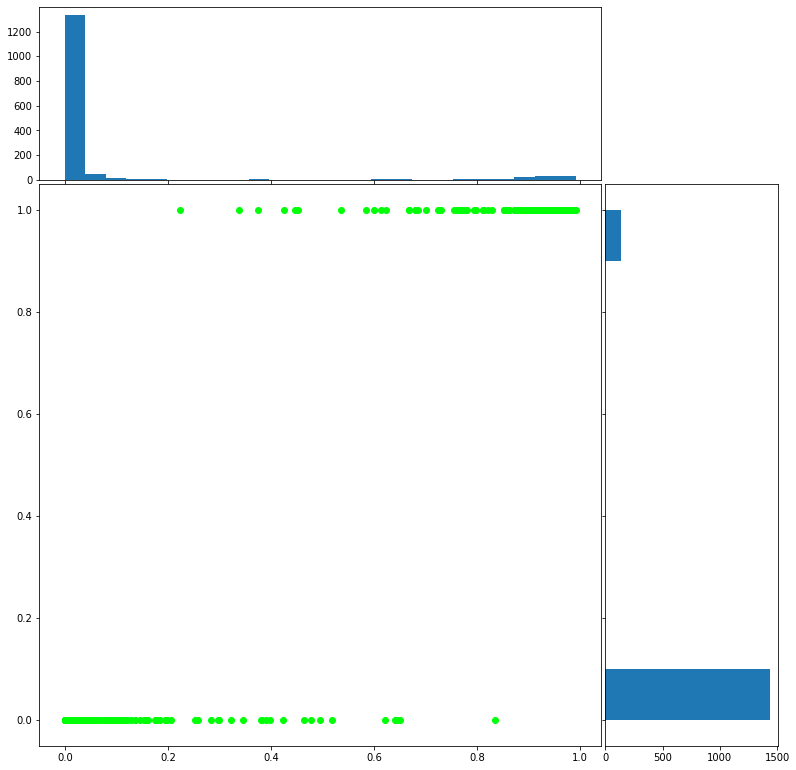


Below is label 39


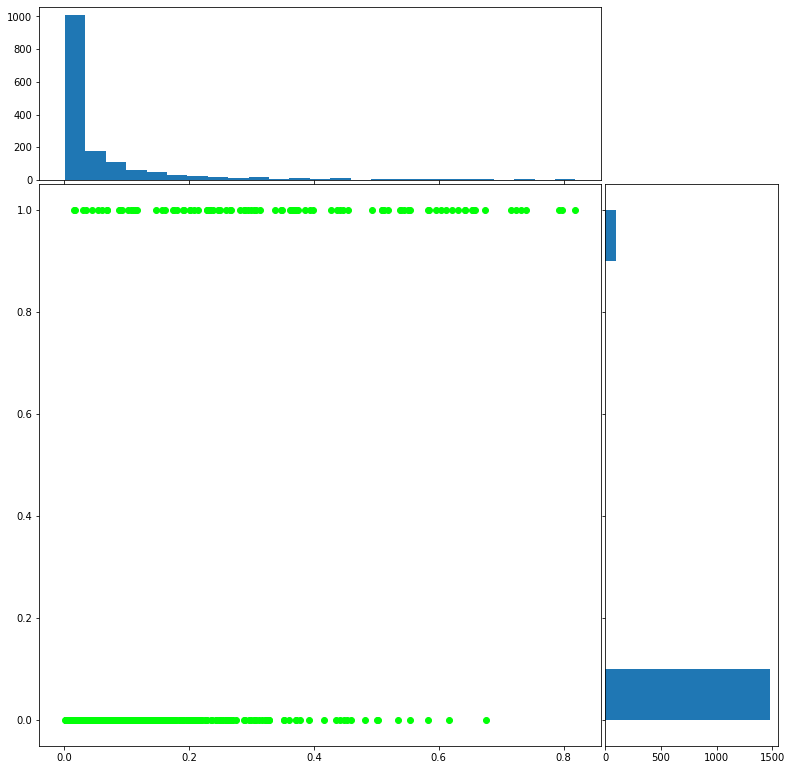


Below is label 40


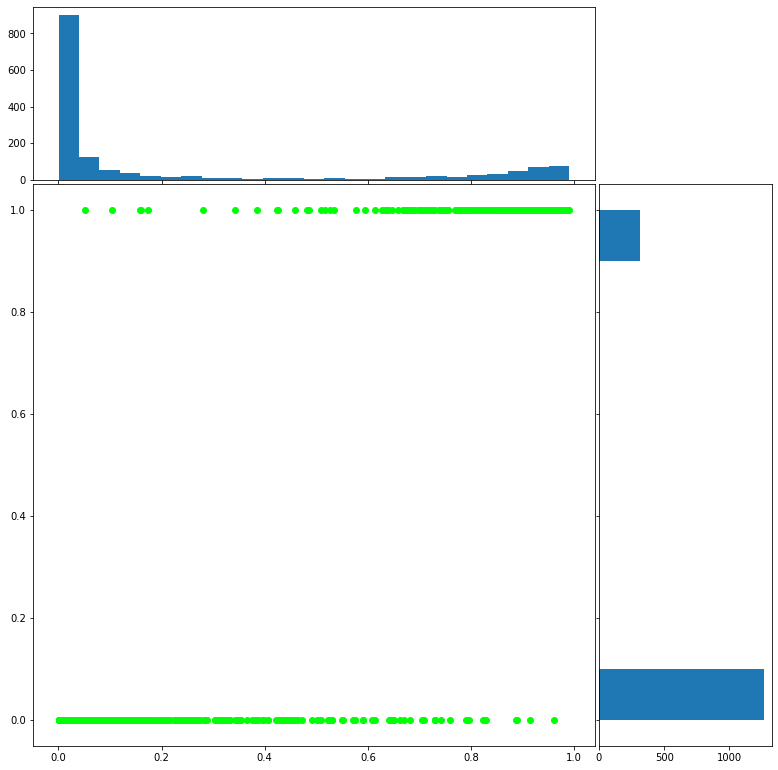


Below is label 41


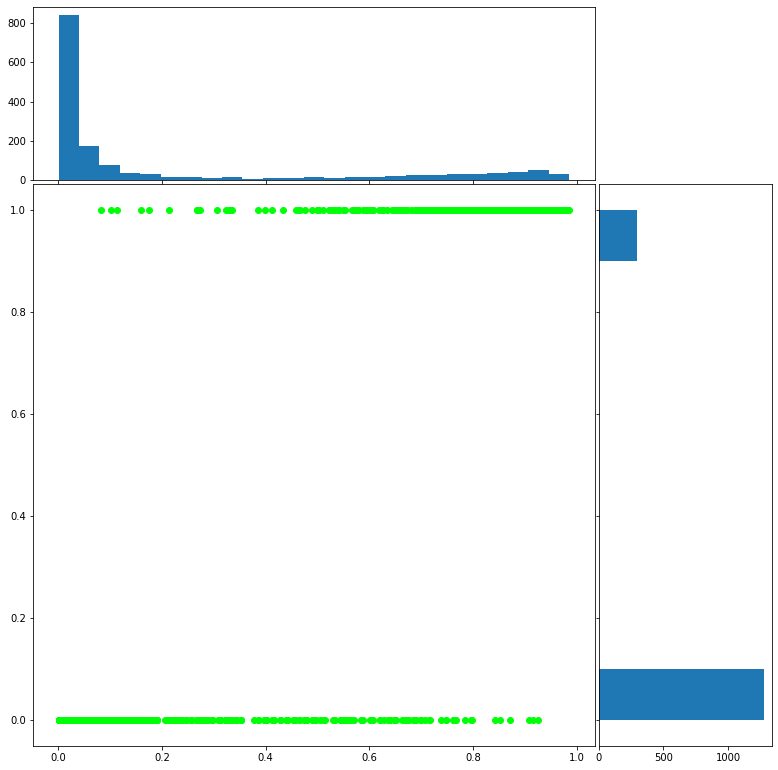


Below is label 42


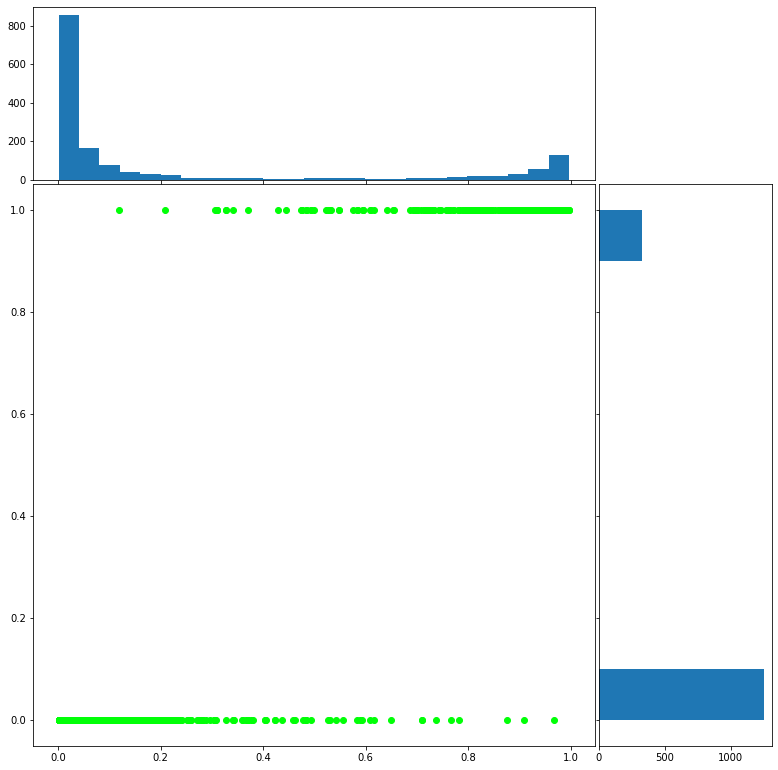


Below is label 43


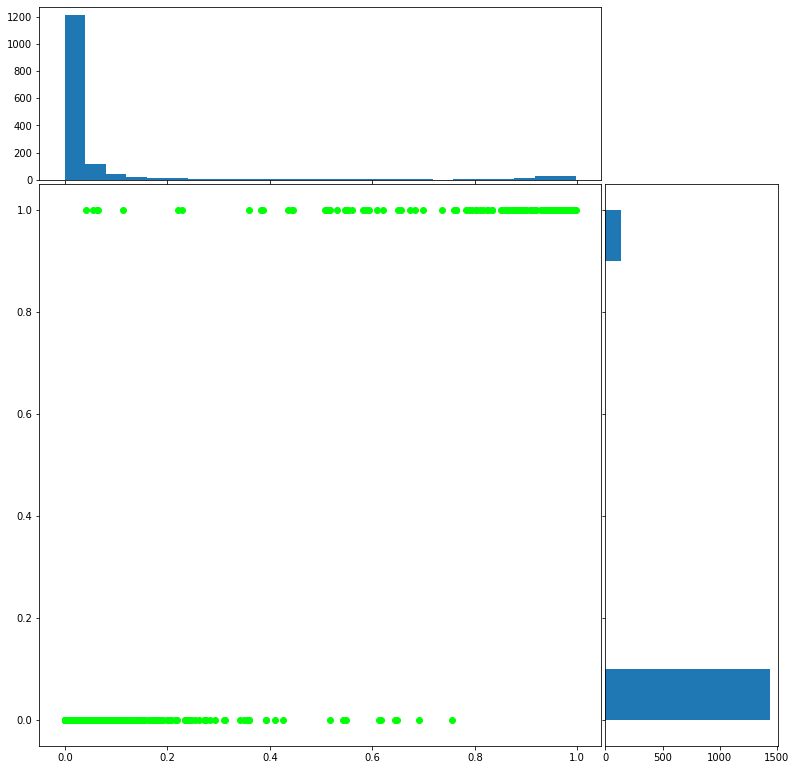


Below is label 44


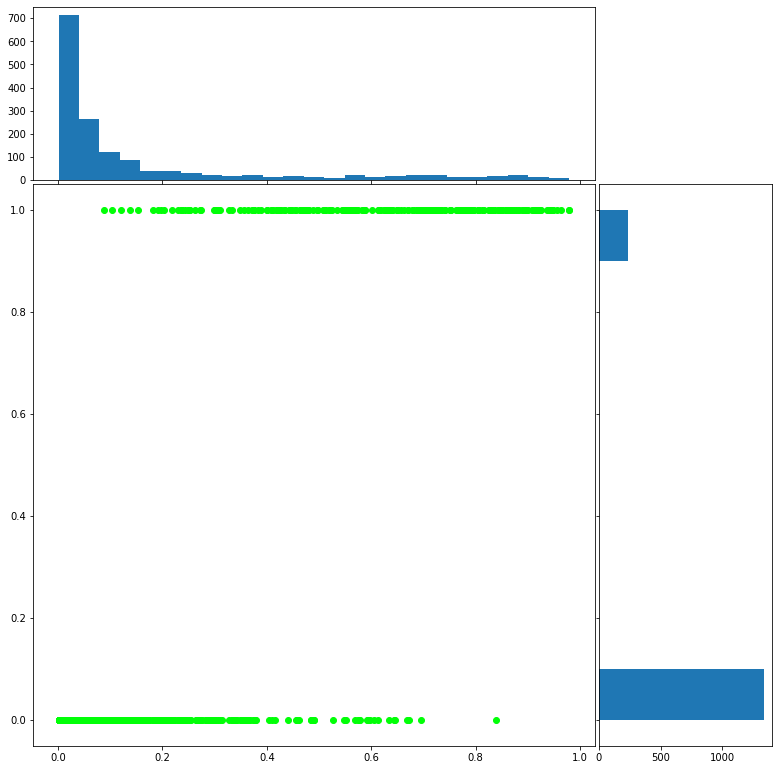


Below is label 45


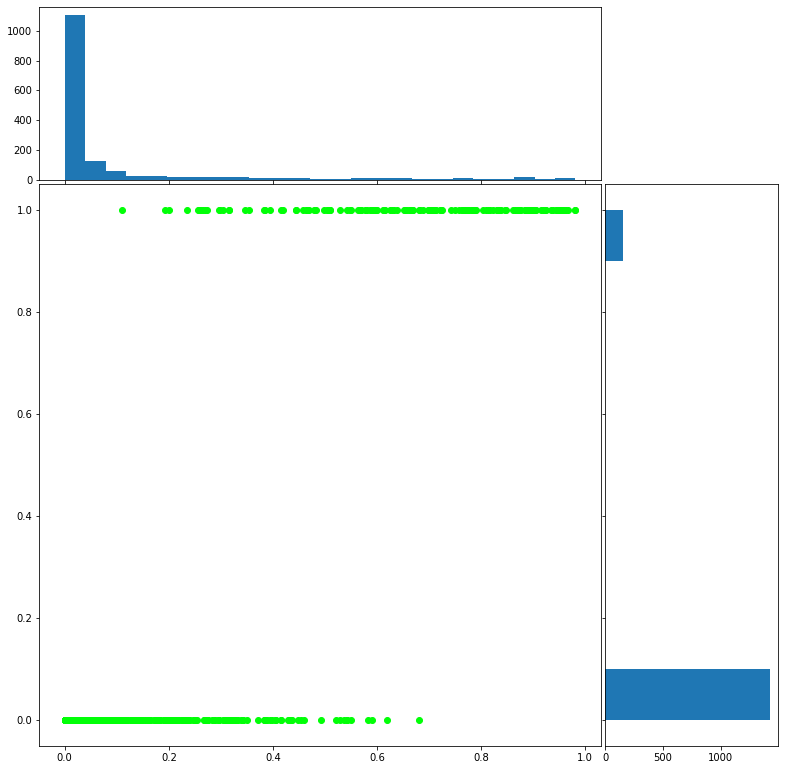


Below is label 46


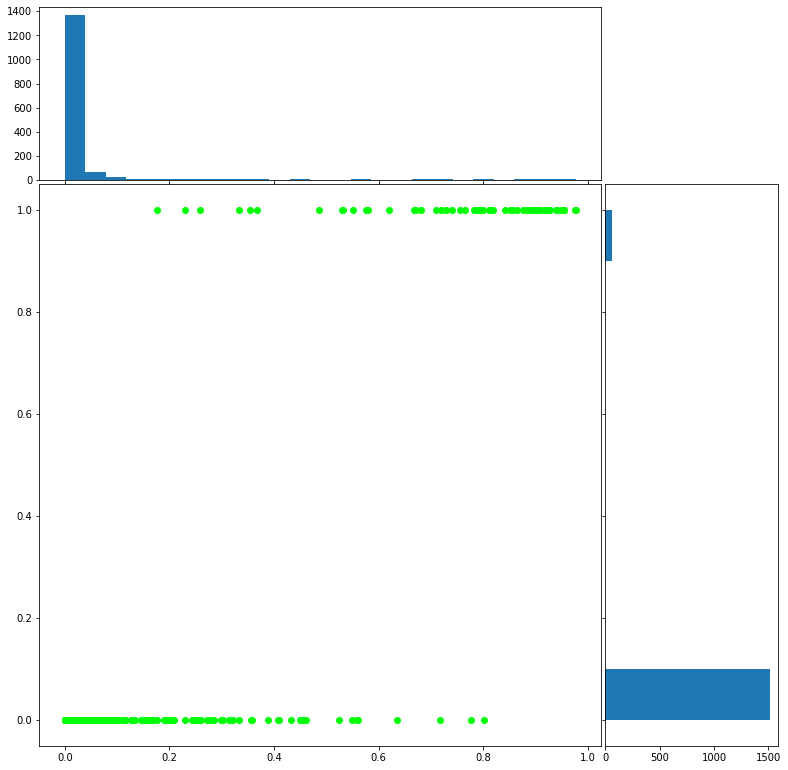


Below is label 47


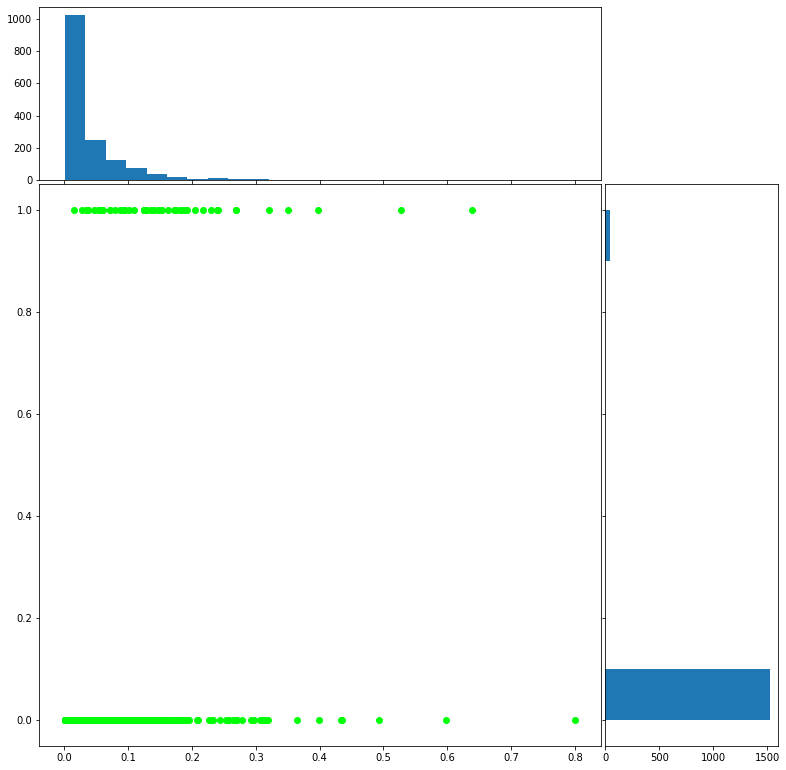


Below is label 48


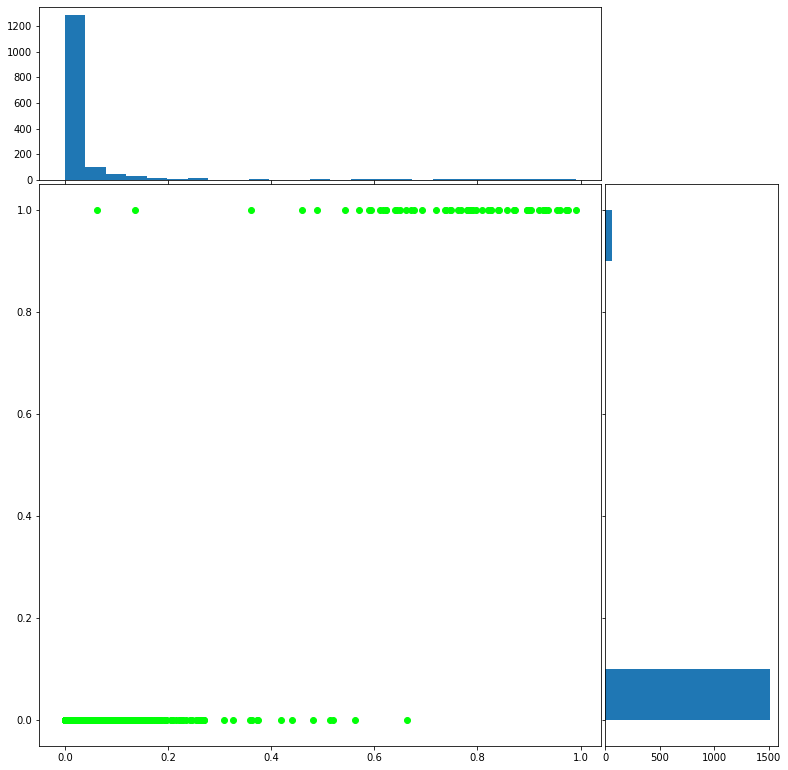


Below is label 49


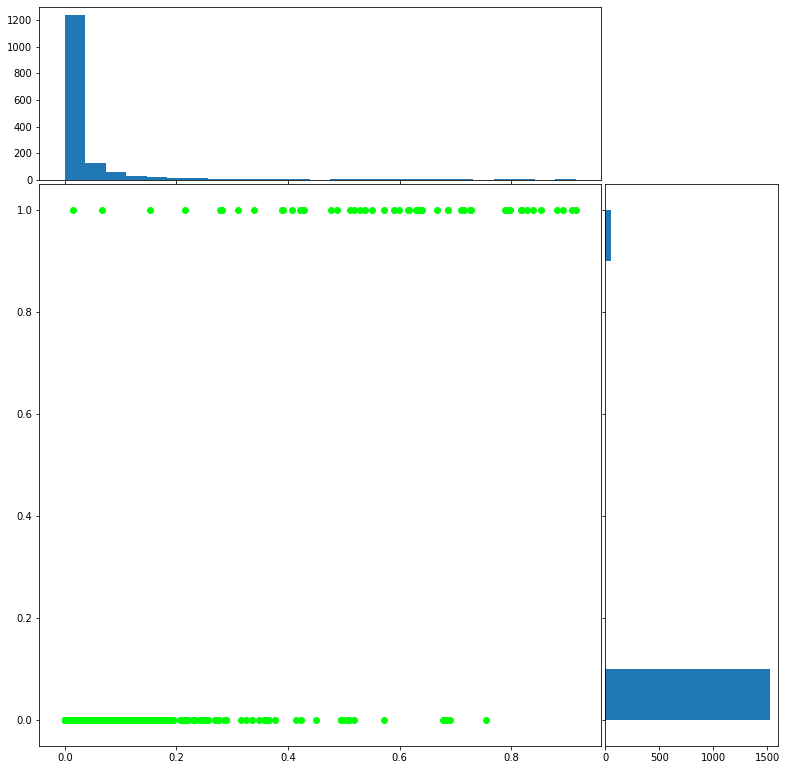

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y,c="#01ff07",)
    ax_histx.hist(x, bins=25)
    ax_histy.hist(y, bins=10, orientation='horizontal')

for i in range(0,50):
  # some random data
  #x = np.random.randn(1000)
  #y = np.random.randn(1000)
  print()
  print("Below is label "+ str(i) )
  y = val_targets[:,i]
  x = val_outputs[:,i]

  # definitions for the axes
  left, width = 0.1, 0.65
  bottom, height = 0.1, 0.65
  spacing = 0.005

  rect_scatter = [left, bottom, width, height]
  rect_histx = [left, bottom + height + spacing, width, 0.2]
  rect_histy = [left + width + spacing, bottom, 0.2, height]

  # start with a square Figure
  fig = plt.figure(figsize=(12, 12))

  ax = fig.add_axes(rect_scatter)
  ax_histx = fig.add_axes(rect_histx, sharex=ax)
  ax_histy = fig.add_axes(rect_histy, sharey=ax)

  # use the previously defined function
  scatter_hist(x, y, ax, ax_histx, ax_histy)

  plt.show()